<a id=IMPORTING-PACKAGES></a>
# IMPORTING PACKAGES

In [4]:
import numpy as np
import matplotlib as mpl
import scipy as sc
import matplotlib.pyplot as plt
import scipy.integrate as scint
import subprocess
import os
from scipy.interpolate import interp1d
from scipy.integrate import simps
from operator import itemgetter
import openpyxl
import pickle
plt.style.use('default')

<a id=FUNCTIONS-METHODS></a>
# FUNCTIONS/METHODS

<a id=POLAR-DATABASE-LOAD-FUNCTION></a>
## POLAR_DATABASE_LOAD() FUNCTION

In [5]:
def polar_database_load(filename='POLARS/POLARS', filepath=os.getcwd(), pick=False):
    '''Reads a given polar database from an Excel file, or loads a previously saved
    and serialized Pickle file.
    
    The Excel file containing the polars should be arranged in a particular manner.
    Specifically, two Excel sheets should be devoted to each of the considered airfoils: one
    for the lift coefficients, and one for the drag coefficients. Thus, assuming that a workbook
    contains merely the polars corresponding to a NACA0015 airfoil, the workbook should contain
    two worksheets named, respectively, 'NACA0015CL' and 'NACA0015CD'. Those worksheets should
    contain, each, a first column with the angle-of-attack, and a set of columns with lift and
    drag coefficients obtained for whatever the Reynolds numbers employed.
    Thus, for example:
    
    ------------------WORKBOOK "POLARSNACA0015.xlsx"------------------
    ----------------------WORKSHEET "NACA0015CL"----------------------
    | COL1 | COL2 | COL3 | COL4 | ............................| COLN |
    |   0  | Re1  |  Re2 |  Re3 | ............................|  Rem |
    ------------------------------------------------------------------
    |  a1  | cl11 | cl21 | cl31 | ............................| clm1 |
    |  a2  | cl12 | cl22 | cl32 | ............................| clm2 |
    |  a3  | cl13 | cl23 | cl33 | ............................| clm3 |
                                ..........                            
                                ..........                            
                                ..........                            
                                ..........                            
                                ..........                            
    |  az  | cl1z | cl2z | cl3z | ............................| clmz | 
    ----------------------WORKSHEET "NACA0015CD"----------------------
    | COL1 | COL2 | COL3 | COL4 | ............................| COLN |
    |   0  | Re1  |  Re2 |  Re3 | ............................|  Rem |
    ------------------------------------------------------------------
    |  a1  | cd11 | cd21 | cd31 | ............................| cdm1 |
    |  a2  | cd12 | cd22 | cd32 | ............................| cdm2 |
    |  a3  | cd13 | cd23 | cd33 | ............................| cdm3 |
                                ..........                            
                                ..........                            
                                ..........                            
                                ..........                            
                                ..........                            
    |  az  | cd1z | cd2z | cd3z | ............................| cdmz |
    
    As observed, the worksheets begin with a '0' in the cel A11, and the rest of the first
    row corresponds to the Reynolds numbers at which the coefficients are obtained.
    The data is stored in columns, each column corresponding to the coefficients that
    correspond to the angle-of-attack stored in the first column.
    For an illustrative example, see 'POLARS.xlsx'.    
    
    **parameters**, **return**, **return types**:

        :param filename: name of the file (Excel/Pickle) to be read. Default is 'POLARS'
        :param filepath: path on which the file is located. Default is current directory.
        :param pickle: boolean flag indicating whether the data is to be loaded from a Pickle
        file. Default is False, meaning that an Excel file is read.        
        :return: dictionary containing read polar data.
        :rtype: dict.
    '''

    # Instantiating Excel and Pickle file names with corresponding extensions.
    file_path_name_xl = "\\".join([filepath, filename + ".xlsx"])
    file_path_name_p = "\\".join([filepath, filename + ".p"])
    ## Conditional for determining which type file is read.
    # If 'pick' is True, then the corresponding Pickle file is loaded (previously read from an Excel file).
    if pick:
        with (open(file_path_name_p, "rb")) as pickle_file:
            # Return statement.
            return pickle.load(pickle_file)
    # If 'pick' is False, then the data is loaded from an Excel file.
    else:
        # Instantiating 'wb_obj' as an Excel workbook object.
        wb_obj = openpyxl.load_workbook(file_path_name_xl)
        # Instantiating 'data' as the data dictionary on which to dump the read datasets.
        data = {}
        # Loop running over the sheets of the Excel workbook.
        for sheetname in wb_obj.sheetnames:
            # The 'sheet' variable addresses the sheet corresponding to the current iteration.
            sheet = wb_obj[sheetname]
            # The 'col_names' is a variable used for assigning names to the datasets that would be
            # read. As the datasets would be either angles-of-attack, and Reynolds-dependent lift
            # and drag coefficients, the 'col_names' variable stores either a string 'angle' (meaning
            # that the corresponding dataset refers to angles-of-attack) or the Reynolds number at
            # which the stored coefficients have been obtained.
            col_names = list()
            # Loop running over the first row to get the names of the columns.
            for column in sheet.iter_cols(1, sheet.max_column):
                col_names.append(column[0].value if column[0].value != 0 else 'angle')
            # Creating the 'datasheet' dictionary that will store the datasets.
            datasheet = {}
            # Loop running over the columns (beginning from the second row), and storing the values
            # on the corresponding datasheet column.
            for _, col in enumerate(sheet.iter_cols(min_row=2, values_only=True)):
                datasheet[col_names[_]] = list(col)
            ## Extending/reversing the datasets and reordering them for having complete in a
            ## negative-to-positive angle-of-attack arrangement. The conditional intends to distinguish
            ## between the cases considering the provided angle-of-attack range.
            # If the provided angle-of-attack range is below 180º, then the extension/reversing consists
            # of reversing the angles and lift coefficients, and mirroring the drag coefficients
            # symmetrically.
            if datasheet['angle'][-1] <= 180:
                # The loop runs over the datasheet keys.
                for key in datasheet.keys():
                    # The angular case is treated separately, as it always consist of a reversing operation.
                    if 'angle' == key:
                        datasheet[key] = [-_ for _ in datasheet[key][:0:-1]] + datasheet[key]
                    else:
                        # The lift case consists of a reversing operation.
                        if "CD" not in sheetname:
                            datasheet[key] = [-_ for _ in datasheet[key][:0:-1]] + datasheet[key]
                        # The drag case consists of a mirroring operation.
                        else:
                            datasheet[key] = datasheet[key][:0:-1] + datasheet[key]
                    # Casting the result into array format for easing further operations.
                    datasheet[key] = np.array(datasheet[key])
            # If the provided angle-of-attack range is above 180º, then the extension/reversing consist
            # of substracting the constant 360 to the angular values, for which a slicing of the
            # list is necessary.
            elif datasheet['angle'][-1] > 180:
                # Getting the index at which the angular value surpasses 180º.
                index = [_ >= 180 for _ in datasheet['angle']].index(True)
                # The loop runs over the datasheet keys.
                for key in datasheet.keys():
                    # The angular cas is treated separately, as it always consist of a reversing operation.
                    if 'angle' == key:
                        # The original dataset is splitted into positive and (about-to-be-)negative parts.
                        pos_part = datasheet[key][:index]
                        neg_part = datasheet[key][index:]
                        # The result dataset consists of substracting 360 to each value of the negative part,
                        # whereas the positive part remains.
                        datasheet[key] = [_ - 360 for _ in neg_part] + pos_part
                    # In the rest of the cases, no operations are needed. The negative part is just set
                    # in front of the positive part, to comply with the ascending ordering of the
                    # angle-of-attack.
                    else:
                        datasheet[key] = datasheet[key][index:] + datasheet[key][:index]
                    # Casting the result into array format for easing further operations.
                    datasheet[key] = np.array(datasheet[key])
                                                    
            # Setting the corresponding entrance on the 'data' variable to the datasheet.
            data[sheetname] = datasheet            
        # Storing the file as a pickle, and returning the data-dictionary.
        with open(file_path_name_p, 'wb') as pickle_file:
            pickle.dump(data, pickle_file)
            return data

<a id=DOUBLE-INTERP-FUNCTION></a>
## DOUBLE-INTERP() METHOD FOR PERFORMING DOUBLE INTERPOLATION

In [6]:
def double_interp(x1, y1, x2, y2, x, y, f11, f12, f21, f22):
    '''Double interpolation function given two input variables.

    **parameters**, **return**, **return types**::
    
        :param x1: minimum value of the first variable.
        :param y1: minimum value of the second variable.
        :param x2: maximum value of the first variable.
        :param y2: maximum value of the second variable.
        :f11: value of the function to interpolate at (x1, y1).
        :f12: value of the function to interpolate at (x1, y2).
        :f21: value of the function to interpolate at (x2, y1).
        :f22: value of the function to interpolate at (x2, y2).
        :return: interpolated value.
        :rtype: real (float).   
    '''
    
    # Checks whether a single or double interpolation is required. If x1=x2 or y1=y2, then
    # a single interpolation formula is employed.
    if x1 == x2:
        # Single interpolation formula in case x1=x2.
        interp = f11 + ((f12 - f11)/(y2 - y1))*(y - y1)
    elif y1 == y2:
        # Single interpolation formula in case y1=y2.
        interp = f11 + ((f21 - f11)/(x2 - x1))*(x - x1)
    else:
        # Terms entering the double interpolation formula.
        term1 = f11*(x2 - x)*(y2 - y)
        term2 = f21*(x - x1)*(y2 - y)
        term3 = f12*(x2 - x)*(y - y1)
        term4 = f22*(x - x1)*(y - y1)
        # Double interpolation formula; checkable in
        # https://en.wikipedia.org/wiki/Bilinear_interpolation
        interp = (1/((x2 - x1)*(y2 - y1)))*(term1 + term2 + term3 + term4)
    # Return statement.
    return interp

<a id=DYNAMIC-FITTING-FUNCTION></a>
## DYNAMIC_FITTING() METHOD FOR PERFORMING A DYNAMIC POLYNOMIAL FITTING

In [7]:
def dynamic_fitting(x, y, mindeg=4, resmin=1e-3, message=True):
    '''Dynamic polynomial fitting function.

    **parameters**, **return**, **return types**::
    
        :param x: x component of data to be fit.
        :param y: y component of data to be fit.
        :param mindeg: minimum degree of polynomial to be used as fitting. Default is 4.
        :param resmin: minimum residual to tolerate. Default is 1e-3.
        :param message: boolean flag for showing message if polynomial fitting fails. Default is True.
        :return: fitted array.
        :rtype: ndarray.   
    '''
    
    # While loop that runs until the minimum tolerance is reached or fitting fails.
    while True:
        # Calling polyfit with a specific polynomial degree (it is minimum on the first step),
        # and 'full' mode for getting the residuals.
        coefsres = np.polyfit(x, y, mindeg, full=True)
        # Setting fitting coefficients to 'coefs' variable.
        coefs = coefsres[0]
        # Setting residuals of fitting to 'res' variable.
        res = coefsres[1]
        # Conditional for checking if the polynomial fitting provides a valid set of residuals.
        if len(res) == 1:
            # Conditional for checking if the tolerance is reached.
            if res < resmin:
                # Break if it is reached.
                break
            # Conditional for checking if the maximum allowable polynomial degree is reached.
            elif mindeg >= len(x)//2:
                # Augment polynomial degree if it is not.
                mindeg += 1
                # Continue to next iteration step.
                continue
            # Break if maximum allowable polynomial degree is reached.
            elif mindeg >= len(x)//2:
                break
            # Break statement for exiting while loop if any of the stopping conditions
            # (tolerance, maximum degree) is reached.
            break
        # If the provided residual length is not valid, exit loop.
        elif len(res) > 1:
            break
        # If the while loop is broken due to maximum polynomial degree overcoming, then send message.        
        elif mindeg >= len(x)//2:
            # Show message if the boolean flag is True.
            if message:
                print("maximum degree of polynomial reached (" + str(mindeg) + ") without achieving tolerance.")
            # Break statement for exiting the loop.
            break
        else:
            # If none of the breaking statement is reached, then augment polynomial degree.
            mindeg += 1
    # Setting 'yfit' variable to a null array of size len(x).
    yfit = np.zeros(len(x))
    # Performing fitting based on fitting coefficient value.s
    for e, _ in enumerate(coefs[::-1]):
        yfit += coefs[len(coefs) - 1 - e]*x**(e)
    # Return statement.
    return yfit

<a id=EXPERIMENTAL-NUMERICAL-DATA-LOADING></a>
# EXPERIMENTAL-NUMERICAL DATA-LOADING

<a id=POLAR-DATABASE></a>
## POLAR DATABASE FROM 'POLARS.XLSX' FILE

The following two code snippets are intended to show the difference between loading a database from an Excel file, and loading it directly from a serialized (previously pre-processed) database. In the latter case, the loading operation is much more efficient (i.e. less time-consuming), because the code does not require to open an Excel file, read each entry, dump it to a separate variable, and perform the extending/reversing polar operations. It just loads an object (a Pickle file), which is in binary format and has been stored when pre-processing the database on a first run.

The function argument that determines whether the pre-processing is performed or, instead, the serialized file is read, is the parameter 'pick' ([see documentation in the corresponding section](#POLAR-DATABASE-LOAD-FUNCTION)). By default, 'pick' is set equal to <code Python>False</code>, so the first code snippet performs the loading and pre-processing of the Excel file, whereas the second loads a serialized Pickle file instead. The difference in the computing times (400 ms vs 20 ms approximately) shows the importance of having a serialized object for these kind of operations.

In [8]:
polars = polar_database_load()

In [9]:
polars = polar_database_load(pick=True)

<a id=CIAPPI-DATA-LOADING></a>
## CIAPPI DATA-LOADING

<a id=THESIS-DATA></a>
### THESIS DATA

In [10]:
# phi-tau data from phi-tau diagram.
## BEM data.
Ciappiphitau, Ciappitau = np.loadtxt(open("CiappiData/2021Ciappi_torque_vs_phi.txt").readlines(), usecols=(0, 1), delimiter="\t", unpack=True)
## k-omega model data.
komegaphitau, komegatau = np.loadtxt(open("CiappiData/2021unsteadykomega_torque_vs_phi.txt").readlines(), usecols=(0, 1), delimiter="\t", unpack=True)
# phi-power data from phi-power diagram.
## BEM data.
Ciappiphipower, Ciappipower = np.loadtxt(open("CiappiData/2021Ciappi_power_vs_phi.txt").readlines(), usecols=(0, 1), delimiter="\t", unpack=True)
## k-omega model data.
komegaphipower, komegapower = np.loadtxt(open("CiappiData/2021unsteadykomega_power_vs_phi.txt").readlines(), usecols=(0, 1), delimiter="\t", unpack=True)
# flowrate-dp data from flowrate-dp diagram.
## BEM data.
Ciappiqdp_st_to_st, Ciappidp_st_to_st = np.loadtxt(open("CiappiData/2021Ciappi_deltap_vs_flowrate.txt"), usecols=(0, 1), delimiter="\t", unpack=True)
## k-omega model data.
komegaqdp_st_to_st, komegadp_st_to_st = np.loadtxt(open("CiappiData/2021unsteadykomega_deltap_vs_flowrate.txt"), usecols=(0, 1), delimiter="\t", unpack=True)
# phi-eff data from phi-eff diagram.
## BEM data.
Ciappiphieff, Ciappieff = np.loadtxt(open("CiappiData/2021Ciappi_eff_vs_phi.txt"), usecols=(0, 1), delimiter="\t", unpack=True)
## k-omega model data.
komegaphieff, komegaeff = np.loadtxt(open("CiappiData/2021unsteadykomega_eff_vs_phi.txt"), usecols=(0, 1), delimiter="\t", unpack=True)
# axialvel-tanvelvar data from axialvel-tanvelvar diagram.
## actuator disc model data.
CiappiAxialVeltanvelvar, Ciappitanvelvar = np.loadtxt(open("CiappiData/2021Ciappi_axialvel_vs_tanvelvar_ad.txt"), usecols=(0, 1), delimiter="\t", unpack=True)

<a id=CIAPPI-PROVIDED-DATA></a>
### CIAPPI-PROVIDED DATA

In [11]:
# All data columns are read.
CiappiAxialVel, Ciappiphi2, Ciappipres, Ciappidens, Ciappibeta, Ciappicl, Ciappicd, CiappiCIF, CiappicxCIF, CiappicthetaCIF, Ciappitau2, Ciappipower2 = np.loadtxt(open("CiappiData/CiappiDataAxialVel.txt").readlines(), usecols=np.arange(0, 12), skiprows=1, unpack=True)

<a id=CLASSES></a>
# CLASSES

<a id=GEOM-PARAMS></a>
## GEOM_PARAMS CLASS
FOR INSTANTIATING GEOMETRICAL PARAMETERS OF TURBINE STAGE

In [12]:
# CLASS GEOM_PARAMS
class geom_params:
    '''Geometrical parameters of a turbine stage.'''
    
    #####
    ##### Defining methods.
    ##### 
    # Initializer or constructor method.
    def __init__(self,
                 ttype='Wells',
                 N = 50,
                 rcas=0.25,
                 hub_to_tip_ratio=0.75,
                 chord=0.117,
                 airfoil='NACA0015',
                 tip_percent=0.5,
                 Z=7):
        '''Initializes the turbine with the provided input values.
        
        **parameters**, **return**, **return types**:
    
            :param ttype: string specifying turbine type; either 'Wells' or 'Impulse'. Default is
            'Wells'.
            :param N: number of blade elements (discretization). Default is 50.
            :param rcas: casing radius. Default is 0.25.
            :param hub_to_tip_ratio: hub to tip ratio value. Default is 0.75.
            :param chord: chord value. It is possible to provide an array of length N
            establishing the chord value at each blade element. Default is 0.117, which means
            that the chord is constant along the radius.
            :param airfoil: airfoil geometry that corresponds to chord. It is possible to provide
            an array of length N establishing the airfoil geometry at each blade element. Default is
            NACA0015, which means that the whole blade is considered to own a single geometry,
            namely the one of the NACA0015.
            :param tip_percent: tip gap value, in terms of chord percentage. Default is 0.5%.
            :param Z: number of blades. Default is 7.
            :return: instance of 'turbine_geom_params' class.
            :rtype: type(turbine_geom_params), obj.        
        '''
        
        #####
        ##### Declaring attributes.
        #####         
        # Conditional for determining which turbine type is instantiated.
        # If a 'Wells' turbine is instantiated:
        if ttype == "Wells":
            #####
            ##### Setting provided values to attributes.
            #####            
            # Type of turbine.
            self._ttype = 'Wells'
            # Casing radius of turbine.
            self._rcas = rcas
            # Hub-to-tip ratio.
            self._hub_to_tip_ratio = hub_to_tip_ratio
            # Tip percentage.
            self._tip_percent = tip_percent
            # Blade number.
            self._Z = Z
            #####
            ##### Setting calculated values to attributes.
            #####                                 
            # Setting tip radius.
            self._rtip = self.rcas #- self.tip_c
            # Setting hub radius.
            self._rhub = self.rtip*hub_to_tip_ratio
            # Setting differential radial element.
            self._dr = (self._rtip - self._rhub)/N            
            # Setting radial array.
            self._r = np.array([self.rhub + i*self._dr for i in range(N + 1)])  
            # Chord.
            # The conditional structure is intended to cast a single float input value to an array
            # of length equal to the number of blade elements with entries coinciding with the single
            # float value, or to set the 'chord' property of the object equal to the input array or list
            # instead.
            if type(chord) == float:
                self._chord = np.array([chord for _ in self.r])
            elif type(chord) == list:
                self._chord = np.array(chord)
            else:
                self._chord = chord
            # Airfoil.
            # The conditional structure is intended to cast a single string input value to a
            # list of length equal to the number of blade elements coinciding with the single string
            # value, or to set the 'airfoil' property of the object equal to the input array or list
            # instead.
            if type(airfoil) == str:
                self._airfoil = np.array([airfoil for _ in self.r])
            elif type(airfoil) == list:
                self._airfoil = airfoil
            else:
                self._airfoil = list(airfoil)
            # Setting tip percent value.
            self._tip_c = self.tip_percent*self.chord*0.01
            # Setting pitch following 1995Raghunatan.
            self._pitch = 2*np.pi*self.rtip/self.Z - self.chord
            # Setting aspect ratio.
            self._AR = (self.rtip - self.rhub)/self.chord                        
            # Setting solidity array.
            self._sigma = self._Z*self._chord/(2*np.pi*self._r)
        # If an 'Impulse' turbine is instantiated.
        elif ttype == "Impulse":
            # TODO: Not implemented yet. Raising 'NotImplementedError'.
            raise NotImplementedError()
    #####
    ##### Defining methods.
    #####              
    # Declaration of get property rcas for casing radius.
    @property
    def rcas(self):
        return self._rcas
    # Declaration of get property hub_to_tip_ratio for hub-to-tip ratio.
    @property
    def hub_to_tip_ratio(self):
        return self._hub_to_tip_ratio
    # Declaration of get property chord for chord.
    @property
    def chord(self):
        return self._chord
    # Declaration of get property airfoil for airfoil geometry.    
    @property
    def airfoil(self):
        return self._airfoil
    # Declaration of get property tip_percent for tip percent.
    @property
    def tip_percent(self):
        return self._tip_percent
    # Declaration of get property Z for number of blades.
    @property
    def Z(self):
        return self._Z
    # Declaration of get property tip_c for tip clearance.
    @property
    def tip_c(self):
        return self._tip_c
    # Declaration of get property rtip for tip radius.
    @property
    def rtip(self):
        return self._rtip
    # Declaration of get property rhub for hub radius.
    @property
    def rhub(self):
        return self._rhub
    # Declaration of get property pitch for pitch.
    @property
    def pitch(self):
        return self._pitch
    # Declaration of get property AR for aspect ratio.
    @property
    def AR(self):
        return self._AR
    # Declaration of get property r for radial array.
    @property
    def r(self):
        return self._r
    # Declaration of get property sigma for solidity.
    @property
    def sigma(self):
        return self._sigma
    # Declaration of get property dr for radial inter-element spacing.
    @property
    def dr(self):
        return self._dr
       
    # Declaration of set property rcas for casing radius.
    @rcas.setter 
    def rcas(self, value):
        self.__init__(ttype=self._ttype, rcas=value, hub_to_tip_ratio=self._hub_to_tip_ratio,
                     chord=self._chord, tip_percent=self._tip_percent, Z=self._Z)
        return
    # Declaration of set property hub_to_tip_ratio for hub-to-tip ratio.
    @hub_to_tip_ratio.setter
    def hub_to_tip_ratio(self, value):
        self.__init__(ttype=self._ttype, rcas=self._rcas, hub_to_tip_ratio=value,
                     chord=self._chord, tip_percent=self._tip_percent, Z=self._Z)
        return
    # Declaration of set property chord for chord.
    @chord.setter
    def chord(self, value):
        self.__init__(ttype=self._ttype, rcas=self._rcas, hub_to_tip_ratio=self._hub_to_tip_ratio,
                     chord=value, tip_percent=self._tip_percent, Z=self._Z)
        return
    # Declaration of set property airfoil for airfoil geometry.
    @airfoil.setter
    def airfoil(self, value):
        self._airfoil = value
        return
    # Declaration of set property tip_percent for tip percent.
    @tip_percent.setter
    def tip_percent(self, value):
        self.__init__(ttype=self._ttype, rcas=self._rcas, hub_to_tip_ratio=self._hub_to_tip_ratio,
                     chord=self._chord, tip_percent=value, Z=self._Z)
        return
    # Declaration of set property Z for number of blades.
    @Z.setter
    def Z(self, value):
        self.__init__(ttype=self._ttype, rcas=self._rcas, hub_to_tip_ratio=self._hub_to_tip_ratio,
                     chord=self._chord, tip_percent=self._tip_percent, Z=value)
        return

<a id=FLOW-PARAMS></a>
## FLOW_PARAMS CLASS
FOR INSTANTIATING FLOW PARAMETERS ENTERING TO TURBINE STAGE

In [13]:
# CLASS FLOW_PARAMS        
class flow_params:
    '''Flow parameters entering a turbine stage.'''
    
    #####
    ##### Defining methods.
    #####      
    # Initializer or constructor method.
    def __init__(self,
                 p=101325,
                 T=288.15,
                 R=287.058,
                 nu=1.81e-5):        
        '''Initializes a given instance of the input parameters entering a turbine.
        
        **parameters**, **return**, **return types**:
    
            :param p: atmospheric pressure in [Pa]. Default value is 101325 [Pa].
            :param T: ambient temperature in [K]. Default value is 288.15 [K].
            :param R: gas constant in [J/(kg·K)]. Default value is 287.058 [J/(kg·K)]
            :param nu: gas viscosity in [kg/(m·s)]. Default value is 1.81e-5 [kg/(m·s)]            
            :return: instance of 'flow_params' class.
            :rtype: type(flow_params), obj.        
        '''        
        
        #####
        ##### Declaring attributes.
        #####          
        # Atmospheric pressure.
        self._p = p
        # Ambient temperature.
        self._T = T
        # Gas constant.
        self._R = R
        # Fluid viscosity.
        self._nu = nu
        # Calculating density assuming ideal gas. Setting it to 'rho' attribute.
        self._rho = p/(T*R)
        
    #####
    ##### Defining methods.
    #####                    
    # Declaration of get property p for atmospheric pressure.
    @property
    def p(self):
        return self._p
    # Declaration of get property T for ambient temperature.
    @property
    def T(self):
        return self._T
    # Declaration of get property R for gas (air) constant.
    @property
    def R(self):
        return self._R
    # Declaration of get property nu for gas (air) viscosity.
    @property
    def nu(self):
        return self._nu
    # Declaration of get property rho for gas (air) density.
    @property
    def rho(self):
        return self._rho

    # Declaration of set property p for atmospheric pressure.
    @p.setter 
    def p(self, value):
        self.__init__(p=value, T=self._T, R=self._R, nu=self._nu)
        return
    # Declaration of set property T for ambient temperature.
    @T.setter
    def T(self, value):
        self.__init__(p=self._P, T=value, R=self._R, nu=self._nu)
        return
    # Declaration of set property R for gas (air) constant.
    @R.setter
    def R(self, value):
        self.__init__(p=self._P, T=self._T, R=value, nu=self._nu)
        return
    # Declaration of set property nu for gas (air) viscosity.
    @nu.setter
    def nu(self, value):
        self.__init__(p=self._P, T=self._T, R=self._R, nu=value)
        return    

<a id=VELOCITY-TRIANGLE></a>
## VELOCITY_TRIANGLE CLASS
FOR INSTANTIATING A VELOCITY TRIANGLE OF A TURBINE STAGE

In [14]:
# CLASS VELOCITY_TRIANGLE
class velocity_triangle:
    '''Spanwise velocity triangle of a turbine stage.'''
    
    #####
    ##### Defining methods.
    #####      
    # Initializer or constructor method.
    def __init__(self, N=50):
        '''Initializes a given instance of a velocity triangle.
        
        **parameters**, **return**, **return type**:
            :param N: number of blade elements (discretization). Default is 50.
            :return: instance of 'velocity_triangle' class.
            :rtype: type(velocity_triangle), obj.        
        '''        
        
        #####
        ##### Declaring attributes.
        #####  
        # Absolute angle.
        self._alpha = np.zeros(N + 1)
        # Axial component of absolute velocity.
        self._vx = np.zeros(N + 1)
        # Tangential component of absolute velocity.
        self._vtheta = np.zeros(N + 1)
        # Absolute velocity magnitude.
        self._v = np.zeros(N + 1)
        # Tangential velocity.
        self._U = np.zeros(N + 1)
        # Axial component of relative velocity.
        self._wx = np.zeros(N + 1)
        # Tangential component of relative velocity.
        self._wtheta = np.zeros(N + 1)
        # Relative velocity magnitude.
        self._w = np.zeros(N + 1)
        # Relative angle.
        self._beta = np.zeros(N + 1)
        # Flow coefficient.
        self._phi = np.zeros(N + 1)
        # Differential flow-rate.
        self._dq = np.zeros(N + 1)
        # Flow-rate.
        self._q = 0
        # Non-dimensional flow-rate.
        self._Phi = 0
        
    #####
    ##### Defining methods.
    #####                    
    # Declaration of get property alpha for absolute velocity angle.
    @property
    def alpha(self):
        return self._alpha
    # Declaration of get property vx for axial component of absolute velocity.
    @property
    def vx(self):
        return self._vx
    # Declaration of get property vtheta for tangential component of absolute velocity.
    @property
    def vtheta(self):
        return self._vtheta
    # Declaration of get property v for magnitude of absolute velocity.
    @property
    def v(self):
        return self._v
    # Declaration of get property U for tangential velocity.
    @property
    def U(self):
        return self._U
    # Declaration of get property wx for axial component of relative velocity.
    @property
    def wx(self):
        return self._wx
    # Declaration of get property wtheta for tangential component of relative velocity.
    @property
    def wtheta(self):
        return self._wtheta
    # Declaration of get property w for magnitude of relative velocity.
    @property
    def w(self):
        return self._w
    # Declaration of get property beta for relative velocity angle.
    @property
    def beta(self):
        return self._beta
    # Declaration of get property phi for flow coefficient.
    @property
    def phi(self):
        return self._phi
    # Declaration of get property dq for differential flow-rate value.
    @property
    def dq(self):
        return self._dq
    # Declaration of get property q for flow-rate value.
    @property
    def q(self):
        return self._q
    # Declaration of get property Phi for dimensionless flow-rate value.
    @property
    def Phi(self):
        return self._Phi
    
    # Declaration of set property alpha for absolute velocity angle.
    @alpha.setter 
    def alpha(self, value):
        assert len(value) == len(self._alpha), 'Provide an array of size ' + len(self._alpha) + '; current array has size ' + str(len(value))
        self._alpha = value
        return
    # Declaration of set property vx for axial component of absolute velocity.
    @vx.setter
    def vx(self, value):
        assert len(value) == len(self._vx), 'Provide an array of size ' + len(self._vx) + '; current array has size ' + str(len(value))
        self._vx = value
        return
    # Declaration of set property vtheta for tangential component of absolute velocity.
    @vtheta.setter
    def vtheta(self, value):
        assert len(value) == len(self._vtheta), 'Provide an array of size ' + len(self._vtheta) + '; current array has size ' + str(len(value))
        self._vtheta = value
        return
    # Declaration of set property v for magnitude of absolute velocity.
    @v.setter
    def v(self, value):
        assert len(value) == len(self._v), 'Provide an array of size ' + len(self._v) + '; current array has size ' + str(len(value))
        self._v = value
        return
    # Declaration of set property U for tangential velocity.
    @U.setter 
    def U(self, value):
        assert len(value) == len(self._U), 'Provide an array of size ' + len(self._U) + '; current array has size ' + str(len(value))
        self._U = value
        return
    # Declaration of set property wx for axial component of relative velocity.
    @wx.setter
    def wx(self, value):
        assert len(value) == len(self._wx), 'Provide an array of size ' + len(self._wx) + '; current array has size ' + str(len(value))
        self._wx = value
        return
    # Declaration of set property wtheta for tangential component of relative velocity.
    @wtheta.setter
    def wtheta(self, value):
        assert len(value) == len(self._wtheta), 'Provide an array of size ' + len(self._wtheta) + '; current array has size ' + str(len(value))
        self._wtheta = value
        return
    # Declaration of set property w for magnitude of relative velocity.
    @w.setter
    def w(self, value):
        assert len(value) == len(self._w), 'Provide an array of size ' + len(self._w) + '; current array has size ' + str(len(value))
        self._w = value
        return        
    # Declaration of set property beta for relative velocity angle.
    @beta.setter
    def beta(self, value):
        assert len(value) == len(self._beta), 'Provide an array of size ' + len(self._beta) + '; current array has size ' + str(len(value))
        self._beta = value
        return
    # Declaration of set property phi for flow coefficient.
    @phi.setter
    def phi(self, value):
        assert len(value) == len(self._phi), 'Provide an array of size ' + len(self._phi) + '; current array has size ' + str(len(value))
        self._phi = value
        return
    # Declaration of set property dq for differential flow-rate value.
    @dq.setter
    def dq(self, value):
        assert len(value) == len(self._dq), 'Provide an array of size ' + len(self._dq) + '; current array has size ' + str(len(value))
        self._dq = value
        return
    # Declaration of set property q for flow-rate value.
    @q.setter
    def q(self, value):        
        self._q = value
        return
    # Declaration of set property Phi for dimensionless flow-rate value.
    @Phi.setter
    def Phi(self, value):
        self._Phi = value
        return

<a id=LOAD-COEFS></a>
## LOAD_COEFS CLASS
FOR INSTANTIATING LOAD AND PROJECTED COEFFICIENTS ON A TURBINE STAGE

In [15]:
# CLASS LOAD_COEFS
class load_coefs:
    '''Spanwise load coefficients on a turbine stage.'''
    
    #####
    ##### Defining methods.
    #####      
    # Initializer or constructor method.
    def __init__(self, N=50):
        '''Initializes a given instance of a class containing loads and coefficients.
        
        **parameters**, **return**, **return type**:
            :param N: number of blade elements (discretization). Default is 50.
            :return: instance of 'loads_coefficients' class.
            :rtype: type(loads_coefficients), obj.        
        '''
        
        #####
        ##### Declaring attributes.
        #####  
        # Reynolds number.
        self._Re = np.zeros(N + 1)
        # Lift coefficient.
        self._cl = np.zeros(N + 1)
        # Drag coefficient.
        self._cd = np.zeros(N + 1)
        # Induced drag coefficient.
        self._cdtc = np.zeros(N + 1)
        # Axial force coefficient.
        self._cx = np.zeros(N + 1)
        # Tangential force coefficient.
        self._ctheta = np.zeros(N + 1)
        # Interference-corrected axial force coefficient.
        self._cxCIF = np.zeros(N + 1)
        # Interference-corrected tangential force coefficient.
        self._cthetaCIF = np.zeros(N + 1)
        # Input coefficient.
        self._cinput = 0
        # Torque coefficient.
        self._ctau = 0
        
    #####
    ##### Defining methods.
    #####     
    # Declaration of get property Re for Reynolds numbers.
    @property
    def Re(self):
        return self._Re
    # Declaration of get property cl for lift coefficients.
    @property
    def cl(self):
        return self._cl
    # Declaration of get property cd for drag coefficients.
    @property
    def cd(self):
        return self._cd
    # Declaration of get property cdtc for induced drag coefficients.
    @property
    def cdtc(self):
        return self._cdtc
    # Declaration of get property cx for axial coefficients.
    @property
    def cx(self):
        return self._cx
    # Declaration of get property ctheta for tangential coefficients.
    @property
    def ctheta(self):
        return self._ctheta
    # Declaration of get property cxCIF for corrected axial coefficients.
    @property
    def cxCIF(self):
        return self._cxCIF
    # Declaration of get property cthetaCIF for corrected tangential coefficients.
    @property
    def cthetaCIF(self):
        return self._cthetaCIF
    # Declaration of get property cinput for input coefficients.
    @property
    def cinput(self):
        return self._cinput
    # Declaration of get property ctau for torque coefficients.
    @property
    def ctau(self):
        return self._ctau
    
    # Declaration of set property Re for Reynolds number.
    @Re.setter 
    def Re(self, value):
        assert len(value) == len(self._Re), 'Provide an array of size ' + len(self._Re) + '; current array has size ' + str(len(value))
        self._Re = value
        return
    # Declaration of set property cl for lift coefficients.
    @cl.setter
    def cl(self, value):
        assert len(value) == len(self._cl), 'Provide an array of size ' + len(self._cl) + '; current array has size ' + str(len(value))
        self._cl = value
        return
    # Declaration of set property cd for drag coefficients.
    @cd.setter
    def cd(self, value):
        assert len(value) == len(self._cd), 'Provide an array of size ' + len(self._cd) + '; current array has size ' + str(len(value))
        self._cd = value
        return
    # Declaration of set property cdtc for induced drag coefficients.
    @cdtc.setter
    def cdtc(self, value):
        assert len(value) == len(self._cdtc), 'Provide an array of size ' + len(self._cdtc) + '; current array has size ' + str(len(value))
        self._cdtc = value
        return    
    # Declaration of set property cx for axial coefficients.
    @cx.setter
    def cx(self, value):
        assert len(value) == len(self._cx), 'Provide an array of size ' + len(self._cx) + '; current array has size ' + str(len(value))
        self._cx = value
        return
    # Declaration of set property ctheta for tangential coefficients.
    @ctheta.setter 
    def ctheta(self, value):
        assert len(value) == len(self._ctheta), 'Provide an array of size ' + len(self._ctheta) + '; current array has size ' + str(len(value))
        self._ctheta = value
        return
    # Declaration of set property cxCIF for corrected axial coefficients.
    @cxCIF.setter
    def cxCIF(self, value):
        assert len(value) == len(self._cxCIF), 'Provide an array of size ' + len(self._cxCIF) + '; current array has size ' + str(len(value))
        self._cxCIF = value
        return
    # Declaration of set property cthetaCIF for corrected tangential coefficients.
    @cthetaCIF.setter
    def cthetaCIF(self, value):
        assert len(value) == len(self._cthetaCIF), 'Provide an array of size ' + len(self._cthetaCIF) + '; current array has size ' + str(len(value))
        self._cthetaCIF = value
        return    
    # Declaration of set property cinput for input coefficients.
    @cinput.setter
    def cinput(self, value):
        self._cinput = value
        return  
    # Declaration of set property ctau for torque coefficients.
    @ctau.setter
    def ctau(self, value):
        self._ctau = value
        return         

<a id=POWER-OUTPUT></a>
## POWER_OUTPUT CLASS
FOR INSTANTIATING ENERGETIC OUTPUTS OF A TURBINE STAGE

In [16]:
# CLASS POWER_OUTPUT
class power_output:
    '''Energetic outpus of a turbine stage.'''
    
    #####
    ##### Defining methods.
    #####      
    # Initializer or constructor method.
    def __init__(self, N=50):
        '''Initializes a given instance of a class containing the energetic outputs of a turbine stage.
        
        **parameters**, **return**, **return type**:
            :param N: number of blade elements (discretization). Default is 50.
            :return: instance of 'power_output' class.
            :rtype: type(power_output), obj.        
        '''
        
        #####
        ##### Declaring attributes.
        #####  
        # Radially-varying differential torque.
        self._difftau = np.zeros(N + 1)
        # Radially-varying differential power.
        self._diffpower = np.zeros(N + 1)
        # Radially-varying static-to-static pressure drop.
        self._dp_st_to_st = np.zeros(N + 1)
        # Radially-varying total-to-static pressure drop.
        self._dp_tot_to_st = np.zeros(N + 1)
        # Radially-varying total-to-total pressure drop.
        self._dp_tot_to_tot = np.zeros(N + 1)
        # Radially-varying viscous losses.
        self._dpvisc = np.zeros(N + 1)
        # Radially-varying kinetic losses.
        self._dpk = np.zeros(N + 1)
        # Radially-varying efficiency.
        self._deff = np.zeros(N + 1)
        # Integrated torque value.
        self._tau = 0
        # Integrated power.
        self._power = 0
        # Non-dimensional power.
        self._Pi = 0
        # Integrated static-to-static pressure drop.
        self._p_st_to_st = 0
        # Integrated total-to-static pressure drop.
        self._p_tot_to_st = 0
        # Non-dimensional integrated total-to-static pressure drop.
        self._Psi = 0
        # Integrated total-to-total pressure drop.
        self._p_tot_to_tot = 0
        # Integrated viscous losses.
        self._pvisc = 0
        # Integrated kinetic losses.
        self._pk = 0
        # Integrated efficiency.
        self._eff = 0
        # Efficiency coming from non-dimensional quantities.
        self._Eta = 0

    #####
    ##### Defining methods.
    #####     
    # Declaration of get property difftau for differential torque.
    @property
    def difftau(self):
        return self._difftau
    # Declaration of get property diffpower for differential power.
    @property
    def diffpower(self):
        return self._diffpower
    # Declaration of get property dp_st_to_st for differential static-to-static pressure-drop.
    @property
    def dp_st_to_st(self):
        return self._dp_st_to_st
    # Declaration of get property dp_tot_to_st for differential total-to-static pressure-drop.
    @property
    def dp_tot_to_st(self):
        return self._dp_tot_to_st
    # Declaration of get property dp_tot_to_tot for differential total-to-total pressure-drop.
    @property
    def dp_tot_to_tot(self):
        return self._dp_tot_to_tot
    # Declaration of get property dpvisc for differential pressure-drop due to viscous losses.
    @property
    def dpvisc(self):
        return self._dpvisc
    # Declaration of get property dpk for differential pressure-drop due to kinetic losses.
    @property
    def dpk(self):
        return self._dpk
    # Declaration of get property deff for differential efficiency.
    @property
    def deff(self):
        return self._deff
    # Declaration of get property tau for torque.
    @property
    def tau(self):
        return self._tau
    # Declaration of get property power for power.
    @property
    def power(self):
        return self._power
    # Declaration of get property Pi for dimensionless power.
    @property
    def Pi(self):
        return self._Pi
    # Declaration of get property p_st_to_st for static-to-static pressure-drop.
    @property
    def p_st_to_st(self):
        return self._p_st_to_st
    # Declaration of get property p_tot_to_st for total-to-static pressure-drop.
    @property
    def p_tot_to_st(self):
        return self._p_tot_to_st
    # Declaration of get property p_tot_to_tot for total-to-total pressure-drop.
    @property
    def p_tot_to_tot(self):
        return self._p_tot_to_tot
    # Declaration of get property Psi for dimensionless total-to-total pressure-drop.
    @property
    def Psi(self):
        return self._Psi
    # Declaration of get property pvisc for pressure-drop due to viscous losses.
    @property
    def pvisc(self):
        return self._pvisc
    # Declaration of get property pk for pressure-drop due to kinetic losses.
    @property
    def pk(self):
        return self._pk
    # Declaration of get property eff for efficiency.
    @property
    def eff(self):
        return self._eff
    # Declaration of get property Eta for efficiency coming from dimensionless variables.
    @property
    def Eta(self):
        return self._Eta
    
    # Declaration of set property difftau for differential torque.    
    @difftau.setter 
    def difftau(self, value):
        assert len(value) == len(self._difftau), 'Provide an array of size ' + len(self._difftau) + '; current array has size ' + str(len(value))
        self._difftau = value
        return
    # Declaration of set property diffpower for differential power.
    @diffpower.setter
    def diffpower(self, value):
        assert len(value) == len(self._diffpower), 'Provide an array of size ' + len(self._diffpower) + '; current array has size ' + str(len(value))
        self._diffpower = value
        return
    # Declaration of set property dp_st_to_st for differential static-to-static pressure-drop.
    @dp_st_to_st.setter
    def dp_st_to_st(self, value):
        assert len(value) == len(self._dp_st_to_st), 'Provide an array of size ' + len(self._dp_st_to_st) + '; current array has size ' + str(len(value))
        self._dp_st_to_st = value
        return
    # Declaration of set property dp_tot_to_st for differential total-to-static pressure-drop.
    @dp_tot_to_st.setter
    def dp_tot_to_st(self, value):
        assert len(value) ==len(self._dp_tot_to_st), 'Provide an array of size ' + len(self._dp_tot_to_st) + '; current array has size ' + str(len(value))
        self._dp_tot_to_st = value
        return
    # Declaration of set property dp_tot_to_tot for differential total-to-total pressure-drop.
    @dp_tot_to_tot.setter 
    def dp_tot_to_tot(self, value):
        assert len(value) == len(self._dp_tot_to_tot), 'Provide an array of size ' + len(self._dp_tot_to_tot) + '; current array has size ' + str(len(value))
        self._dp_tot_to_tot = value
        return
    # Declaration of set property dpvisc for differential pressure-drop due to viscous losses.
    @dpvisc.setter
    def dpvisc(self, value):
        assert len(value) == len(self._dpvisc), 'Provide an array of size ' + len(self._dpvisc) + '; current array has size ' + str(len(value))
        self._dpvisc = value
        return
    # Declaration of set property dpk for differential pressure-drop due to kinetic losses.    
    @dpk.setter
    def dpk(self, value):
        assert len(value) == len(self._dpk), 'Provide an array of size ' + len(self._dpk) + '; current array has size ' + str(len(value))
        self._dpk = value
        return   
    # Declaration of set property deff for differential efficiency.    
    @deff.setter
    def deff(self, value):
        assert len(value) == len(self._deff), 'Provide an array of size ' + len(self._deff) + '; current array has size ' + str(len(value))
        self._deff = value
        return
    # Declaration of set property tau for torque.
    @tau.setter 
    def tau(self, value):        
        self._tau = value
        return
    # Declaration of set property power for power.    
    @power.setter
    def power(self, value):        
        self._power = value
        return
    # Declaration of set property Pi for dimensionless power.
    @Pi.setter
    def Pi(self, value):
        self._Pi = value
        return
    # Declaration of set property p_st_to_st for static-to-static pressure-drop.
    @p_st_to_st.setter
    def p_st_to_st(self, value):
        self._p_st_to_st = value
        return
    # Declaration of set property p_tot_to_st for total-to-static pressure-drop.
    @p_tot_to_st.setter
    def p_tot_to_st(self, value):
        self._p_tot_to_st = value
        return
    # Declaration of set property p_tot_to_tot for total-to-total pressure-drop.
    @p_tot_to_tot.setter 
    def p_tot_to_tot(self, value):
        self._p_tot_to_tot = value
        return
    # Declaration of set property Psi for dimensionless total-to-total pressure-drop.    
    @Psi.setter
    def Psi(self, value):
        self._Psi = value
        return
    # Declaration of set property pvisc for pressure-drop due to viscous losses.    
    @pvisc.setter
    def pvisc(self, value):
        self._pvisc = value
        return
    # Declaration of set property pk for pressure-drop due to kinetic losses.    
    @pk.setter
    def pk(self, value):
        self._pk = value
        return       
    # Declaration of set property eff for efficiency.        
    @eff.setter
    def eff(self, value):
        self._eff = value
        return
    # Declaration of set property Eta for efficiency coming from dimensionless variables.
    @Eta.setter
    def Eta(self, value):
        self._Eta = value
        return

<a id=TURBINE-STAGE></a>
## TURBINE_STAGE CLASS
FOR INSTANTIATING A TURBINE STAGE

In [43]:
# CLASS TURBINE_STAGE
class turbine_stage:
    '''Sets a turbine stage.'''
    
    #####
    ##### Defining methods.
    #####      
    # Initializer or constructor method.
    def __init__(self,
                 ttype='Wells',
                 omega=3600,                 
                 N = 50,
                 rcas=0.25,
                 hub_to_tip_ratio=0.75,
                 chord=0.117,
                 airfoil="NACA0015",
                 tip_percent=0.5,
                 Z=7,
                 p=101325,
                 T=288.15,
                 R=287.058,
                 nu=1.81e-5):
        '''Initializes a given instance of a class containing the a turbine stage.
        
        **parameters**, **return**, **return type**:              
            :param ttype: string specifying turbine type; either 'Wells' or 'Impulse'. Default is
            'Wells'.
            :param omega: rotational speed of turbine stage, in [RPM]. Default is 3600 [RPM].
            :param N: number of blade elements (discretization). Default is 50.
            :param rcas: casing radius. Default is 0.25.
            :param hub_to_tip_ratio: hub to tip ratio value. Default is 0.75.
            :param chord: chord value. Default is 0.117. It can be an element-wise array.
            :param airfoil: geometry of the airfoils of the blade. Default is NACA0015, meaning that
            the airfoil geometry is constant throughout the blade. It can be an element-wise array.
            :param tip_percent: tip gap value, in terms of chord percentage. Default is 0.5%.
            :param Z: number of blades. Default is 7.
            :param p: atmospheric pressure in [Pa]. Default value is 101325 [Pa].
            :param T: ambient temperature in [K]. Default value is 288.15 [K].
            :param R: gas constant in [J/(kg·K)]. Default value is 287.058 [J/(kg·K)]
            :param nu: gas viscosity in [kg/(m·s)]. Default value is 1.81e-5 [kg/(m·s)]            
            :return: instance of 'turbine_geom_params' class.
            :rtype: type(turbine_geom_params), obj.     
        '''
        
        #####
        ##### Declaring attributes.
        #####  
        # Type of turbine.
        self._ttype = ttype
        # Rotational speed.
        self._omega = omega*2*np.pi/60
        # Geometrical parameters.
        self._gp = geom_params(ttype=ttype,
                               N=N,
                               rcas=rcas,
                               hub_to_tip_ratio=hub_to_tip_ratio,
                               chord=chord,
                               airfoil=airfoil,
                               tip_percent=tip_percent,
                               Z=Z
                              )
        # Flow parameters.
        self._fp = flow_params(p=p,
                               T=T,
                               R=R,
                               nu=nu
                              )
        # Inlet velocity triangle.
        self._it = velocity_triangle(N=N)
        # Outlet velocity triangle.
        self._ot = velocity_triangle(N=N)
        # Coefficients.
        self._coefs = load_coefs(N=N)
        # Energetic output.
        self._eout = power_output(N=N)
        
    #####
    ##### Defining methods.
    #####     
    # Declaration of get property ttype for turbine stage type.
    @property
    def ttype(self):
        return self._ttype
    # Declaration of get property omega for rotational speed.
    @property
    def omega(self):
        return self._omega
    # Declaration of get property gp for turbine stage geometrical parameters.
    @property
    def gp(self):
        return self._gp
    # Declaration of get property fp for turbine stage flow parameters.
    @property
    def fp(self):
        return self._fp
    # Declaration of get property it for turbine stage inlet velocity triangle.
    @property
    def it(self):
        return self._it
    # Declaration of get property ot for turbine stage outlet velocity triangle.
    @property
    def ot(self):
        return self._ot
    # Declaration of get property coefs for turbine stage load coefficients.
    @property
    def coefs(self):
        return self._coefs
    # Declaration of get property eout for turbine energetic output.
    @property
    def eout(self):
        return self._eout
    
    # Declaration of set property omega for rotational speed.
    @omega.setter
    def omega(self, value):
        self._omega = value
        return   
    
    # BEM method.
    def BEM(self, phi_q_v, polars, inputparam='phi', mode='3DNOAD'):
        '''Applies the momentum element method to the current turbine stage.
        
        **parameters**, **return**, **return type**:                    
            :param phi_q_v: input parameter value for which the BEM method is applied. It can
            be either a flow coefficient value (phi), a flow-rate value (q) or an axial velocity
            value (vx).
            :param polars: dictionary of lift and drag coefficients at different Reynolds numbers for
            a set of distinct airfoils from which to interpolate the lift and drag coefficients
            upon each of the blade elements.
            :param inputparam: string determining the type of input parameter. It can be either
            'phi' (stipulating flow coefficient), 'flowrate' (flow-rate) or 'axialvel'
            (axial velocity). Default is 'phi'.
            :param mode: string determining the model of BEM to be applied. It can be either
            '3DNOAD' (semi-3D BEM model without actuator disk) or '3DAD' (semi-3D BEM model with
            actuator disk). Default is '3DNOAD'.
            :return: None.
            :rtype: None.        
        '''
        
        # Asserts whether the 'mode' input variable is valid. If not, it raises an error message.
        assert mode in ["3DNOAD", "3DAD"], "Provide a valid mode for applying the BEM method, either '3DNOAD' or '3DAD''; current value is " + str(mode)
        
        # Conditional determining which of the BEM models is to be applied.
        if mode == '3DNOAD':
            # Call to external function 'BEM_wells_noad'.
            BEM_wells_noad(self, phi_q_v, self.omega, polars, inputparam, refvel='it')
        elif mode == '3DAD':
            # Call to external function 'BEM_wells_ads'.
            BEM_wells_ad(self, phi_q_v, self.omega, polars, inputparam, refvel='it')
        # Return statement.
        return

<a id=BEM-MODELS></a>
# BEM MODELS

<a id=SEMI-3D-MODEL></a>
## SEMI-3D MODEL

In [66]:
# BEM_wells_noad() method.
def BEM_wells_noad(ts, phi_q_v, omega, polars, inputparam="phi", refvel='it'):
    '''Applies the blade-element momentum theory (BEM) to a Wells-type turbine stage.
    
    The BEM theory is applied as formulated in the Ph.D. dissertation thesis of Ciappi (2021),
    available in the link https://flore.unifi.it/handle/2158/1245178#.YWXWWRpBzIV.

    - **parameters**, **returns**, **return types**

    :param ts: instance of the turbine_stage class to which the BEM is to be applied.
    :param phi_q_v: input parameter, either a flow coefficient (phi) a flow-rate value (q) or
    an axial velocity value (vx). It may be either an array-like structure, specifying phi, q
    or v for each blade element, or a single value, in which the provided value is set equal
    to all the blade elements.
    :param omega: rotational speed of the turbine [rad/s].
    :param polars: a dictionary containing the polars of the element airfoils.
    :param inputparam: string representing the type of input provided; it is "phi" for indicating
    a flow coefficient, "q" for a flow-rate, "vx" for an axial velocity or "it" for a pre-established
    inlet velocity triangle. Default is "phi".
    :param refvel: string representing the referential velocity employed for calculating loads
    and velocity-dependent outputs; it is "it" for setting the referential velocity equal to the
    relative velocity magnitude of the inlet velocity triangle, or 'ave' for setting it equal to
    the relative velocity magnitude based on the actuator disk value (the axial component being
    the average of downstream and upstream velocities). Default is "it".
    :return: None.
    :rtype: None.    
    '''
    
    #####
    ##### ASSERTIONS
    #####
    # Assertion for checking that the input parameter matches an accepted value.
    assert inputparam in ["phi", "q", "vx", "it"], "Provide a valid inputparam mode: 'phi', 'q', 'vx' or 'it'."
    # Assertion for checking that the string representing the referential velocity "refvel" has a valid value.
    assert refvel in ["it", "ave"], "Provide a valid 'refvel' value: 'it' or 'ave'."
    # Conditional for asserting that the input parameter has the same length of the array of blade elements.
    if isinstance(phi_q_v, np.ndarray):
        assert len(phi_q_v) == len(ts.gp.r), 'In case the input variable is meant to be an array  provide it so that its length equals the number of blade elements. Input array has a length of ' + str(len(phi_q_v)) + ', and number of blade elements is ' + str(len(ts.gp.r)) + '.'
    
    #####
    ##### SET A REFERENCE VALUE FOR CALCULATING REYNOLDS AND OUTPUT COEFFICIENTS THAT DEPEND ON INPUT VELOCITY?
    #####
        
    #####
    ##### UPSTREAM VELOCITY-TRIANGLE CALCULATION
    #####
    # Conditional for checking whether "inputparam" is "it"; in such a case, a pre-established
    # velocity triangle is provided as an input, and it is not necessary to begin the calculations
    # from determining the inlet velocity triangle.
    if inputparam == "it":
        Um = ts.it.U[len(ts.it.U)//2]
        phi = ts.it.phi[len(ts.it.phi)//2]
        dq_aux = np.abs(ts.it.dq)
    else:
        # Tangential velocity calculation.
        ts.it.U = -np.array([omega*_ for _ in ts.gp.r])
        ts.ot.U = ts.it.U
        # Midspan tangential velocity instantiation.
        Um = ts.it.U[len(ts.it.U)//2]
        # Axial velocity, midspan flow parameter and flow coefficient calculations depending on the provided input parameter.
        if inputparam=="phi":
            # If the input parameter is a flow coefficient, then:
            # check, first, if the input variable is an array or nts.ot.        
            if isinstance(phi_q_v, np.ndarray):
                # If the is, then set the axial velocity to the product of the input parameter and the local (element-wise) tangential velocity.
                ts.it.vx = np.array([_[0]*_[1] for _ in zip(phi_q_v, ts.it.U)])
            else:
                # If it isn't, then the axial velocity of the inlet velocity triangle is obtained by multiplying phi and Um, assuming a constant axial velocity radially.
                ts.it.vx = np.array([phi_q_v*Um for _ in ts.gp.r])                    
            # the midspan flow parameter coincides with the input value.
            phi = phi_q_v
            # The differential flow-rate is calculated from its definition.
            ts.it.dq = 2*np.pi*ts.gp.r*ts.it.vx
            # The flow-rate is calculated by integration.
            ts.it.q = simps(ts.it.dq, dx=ts.gp.dr)
        elif inputparam=="q":
            # If the input parameter is a flow rate value, then:
            # check, first, if the input variable is an array or nts.ot.
            if isinstance(phi_q_v, np.ndarray):
                # If it is, then set the axial velocity from its definition of differential flow-rate.
                ts.it.vx = phi_q_v/(2*np.pi*ts.gp.r)
                # Set the differential flow-rate to the input variable.
                ts.it.dq = phi_q_v
                # Set the flow-rate to the integral value of the differential flow-rate.
                ts.it.q = simps(ts.it.dq, dx=ts.gp.dr)
            else:
                # If it isn't, then set the axial velocity from its definition of integral flow-rate, assuming constant axial velocity of the inlet velocity triangle.
                ts.it.vx = np.array([phi_q_v/(np.pi*(ts.gp.rtip**2 - ts.gp.rhub**2)) for _ in ts.gp.r])
                # Set the integral flow-rate to the input variable.
                ts.it.q = phi_q_v
                # Set the differential flow-rate from its definition.
                ts.it.dq = 2*np.pi*ts.gp.r*ts.it.vx
            # The midspan flow parameter is obtained by dividing the axial velocity with the midspan tangential velocity.
            phi = ts.it.vx[len(ts.it.vx)//2]/Um
        else:
            # Check, first, if the input variable is an array or nts.ot.
            if isinstance(phi_q_v, np.ndarray):
                #If it is, then set the axial velocity component of the inlet velocity triangle to the input variable.
                ts.it.vx = phi_q_v
            else:
                # If it isn't, then set the axial velocity component of the inlet velocity triangle to a constant value equal to the input parameter.
                ts.it.vx = np.array([phi_q_v for _ in ts.gp.r])
            # The midspan flow paramter is obtained by dividing the axial velocity with the midspan tangential velocity.
            phi = ts.it.vx[len(ts.it.vx)//2]/Um    
            # The differential flow-rate is calculated from its definition.
            ts.it.dq = 2*np.pi*ts.gp.r*ts.it.vx
            # The flow-rate is calculated by integration.
            ts.it.q = simps(ts.it.dq, dx=ts.gp.dr)
        # Setting the non-dimensional flow-coefficient at the input triangle.
        ts.it.Phi = ts.it.q/(omega*(2*ts.gp.rtip)**3)
        # The alpha angle (between the absolute and tangential velocities) is set to pi/2 by assumption.
        ts.it.alpha = np.array([np.pi/2 for i in range(len(ts.it.alpha))])
        # The magnitude of the absolute velocity is obtained by pitagorean application.
        ts.it.v = np.sqrt(ts.it.vx**2 + ts.it.vtheta**2)
        # The axial component of the relative velocity is set to the axial component of the absolute velocity.
        ts.it.wx = np.array([_ for _ in ts.it.vx])
        # The tangential component of the relative velocity is set to (-) the tangential velocity, from the vectorial identity.
        ts.it.wtheta = np.array([-_ for _ in ts.it.U])
        # The magnitude of the relative velocity is obtained by pitagorean application.
        ts.it.w = np.sqrt(ts.it.wx**2 + ts.it.wtheta**2)
        # The beta1 angle (between the relative and tangential velocities) is obtained from trigonometric relations.
        ts.it.beta = np.arctan(ts.it.wx/ts.it.wtheta)
        # The radially-varying flow coefficient is obtained from its definition.
        ts.it.phi = ts.it.vx/ts.it.U
        # Expressing an auxiliar differential flow-rate as the absolute value of the flow-rate (necessary for loss calculations).
        dq_aux = np.abs(ts.it.dq)
    
    #####
    ##### SETTING REFERENTIAL MAGNITUDE
    #####
    # Declaring 'vx', 'v' and w' as referential velocity magnitudes at the disc and setting them to 0.
    vx = 0
    v = 0
    w = 0
    # Conditional for setting the referential velocity magnitudes according to the value of 'refvel'.
    if refvel == "it":
        # If 'refvel' is 'it', then the referential magnitude is set equal to the inlet velocity triangle's relative magnitude.
        vx = ts.it.vx
        v = ts.it.v
        w = ts.it.w
    else:
        # If 'refvel' is 'ave', then the referential velocity magnitudes are set equal to the velocity magnitudes at the disk.
        vx = 0.5*(ts.ot.vx + ts.it.vx)
        v = np.sqrt(vx**2 + ts.it.vtheta**2)
        w = np.sqrt(vx**2 + ts.it.wtheta**2)
    
    #####
    ##### REYNOLDS CALCULATION AND BILINEAR INTERPOLATION FOR GETTING CL AND CD VALUES
    #####
    # The Reynolds number is obtained from its definition, Re=p·W·c/u, where p is the density and nu the viscosity.        
    ts.coefs.Re = ts.fp.rho*ts.gp.chord*w/ts.fp.nu
    # Loop running over the inlet velocity triangle's relative angle values.
    for e, _ in enumerate(ts.it.beta):
        _ *= 180/np.pi
        # Getting the lift and drag coefficient polars corresponding to current blade element's airfoil geometry.
        polar_cl = polars[ts.gp.airfoil[e] + "CL"]
        polar_cd = polars[ts.gp.airfoil[e] + "CD"]
        # Getting the Reynolds values for which the lift and drag coefficients have been obtained.
        Re_values = list(polar_cl.keys())[1:]
        # Getting the index that determines between which tested Reynolds values falls the current Reynolds, and retrieving those extreme Reynolds values for interpolation.
        minindex = [ts.coefs.Re[e] - __ < 0 for __ in Re_values].index(True) - 1
        Remin = Re_values[minindex]
        Remax = Re_values[minindex + 1]
        # Getting the lift and drag datasets that correspond to the minimum and maximum Reynolds values.
        lifts = [polar_cl[Remin], polar_cl[Remax]]
        drags = [polar_cd[Remin], polar_cd[Remax]]
        # Retrieving the angles-of-attack for which the coefficients have been obtained.
        alpha = list(polar_cl['angle'])
        # Maximum and minimum lift values are determined, given the current angle-of-attack, so that the double interpolation scheme is applied.
        clminmin, clminmax = lifts[0][alpha.index(np.floor(_))], lifts[0][alpha.index(np.ceil(_))]
        clmaxmin, clmaxmax = lifts[1][alpha.index(np.floor(_))], lifts[1][alpha.index(np.ceil(_))]
        # Calling the double_interp() method with current angle-of-attack and Reynolds number, thus determining the lift value.
        ts.coefs.cl[e] = double_interp(np.floor(_), Remin, np.ceil(_), Remax, _, ts.coefs.Re[e], clminmin, clmaxmin, clminmax, clmaxmax)
        # Maximum and minimum drag values are determined, given the current angle-of-attack, so that the double interpolation scheme is applied.
        cdminmin, cdminmax = drags[0][alpha.index(np.floor(_))], drags[0][alpha.index(np.ceil(_))]
        cdmaxmin, cdmaxmax = drags[1][alpha.index(np.floor(_))], drags[1][alpha.index(np.ceil(_))]
        # Calling the double_interp() method with current angle-of-attack and Reynolds number, thus determining the drag value.
        ts.coefs.cd[e] = double_interp(np.floor(_), Remin, np.ceil(_), Remax, _, ts.coefs.Re[e], cdminmin, cdmaxmin, cdminmax, cdmaxmax)        
    # Performing the curve-fitting if the value of the flow parameter is not 0 (null lift value).
    if phi != 0:
        # Lift-fitting.
        ts.coefs.cl = dynamic_fitting(ts.it.beta*180/np.pi, ts.coefs.cl, 2, resmin=1e-2)
        # Drag-fitting.
        ts.coefs.cd = dynamic_fitting(ts.it.beta*180/np.pi, ts.coefs.cd, 2, resmin=1e-2)
    
    #####
    ##### COMPUTATION OF INDUCED DRAG, THRUST AND TANGENTIAL-FORCE COEFFICIENTS
    #####
    # Induced drag coefficients from its formulation.
    ts.coefs.cdtc = ts.coefs.cd + 0.7*np.abs(ts.coefs.cl)*ts.gp.tip_c/(ts.gp.AR*ts.gp.pitch)
    # Projection for obtaining axial coefficient.
    ts.coefs.cx = ts.coefs.cl*np.cos(ts.it.beta) + ts.coefs.cdtc*np.sin(ts.it.beta)
    # Projection for obtaining tangential coefficient.
    ts.coefs.ctheta = -ts.coefs.cl*np.sin(ts.it.beta) + ts.coefs.cdtc*np.cos(ts.it.beta)
    
    #####
    ##### COMPUTATION OF INTERFERENCE-CORRECTED (SOLIDITY-BASED SEMI-EMPIRICAL CORRECTION) THRUST AND TANGENTIAL-FORCE COEFFICIENTS
    #####
    # Correction of axial coefficient.
    ts.coefs.cxCIF = ts.coefs.cx/(1 - ts.gp.sigma**2)
    # Correction of tangential coefficient.
    ts.coefs.cthetaCIF = ts.coefs.ctheta/(1 - ts.gp.sigma**2)
    
    #####
    ##### DOWNSTREAM VELOCITY-TRIANGLE CALCULATION
    #####
    # Conditional for passing in case the beta1 angle is null (no flow).
    if 0 in ts.it.beta:
        pass
    else:
        # Calculation of the absolute angle of the outlet velocity triangle.
        ts.ot.alpha = np.pi/2 - np.arctan((1/np.tan(ts.it.alpha))-(ts.gp.Z*ts.gp.chord*ts.coefs.cthetaCIF)/(4*np.pi*ts.gp.r*np.sin(np.abs(ts.it.beta))**2))
        # The downstream absolute axial velocity component is set equal to the upstream one, by modelization assumption.
        ts.ot.vx = np.array([_ for _ in ts.it.vx])
        # The tangential component is obtained via trigonometrical relation.        
        ts.ot.vtheta = np.abs(ts.ot.vx)/np.tan(ts.ot.alpha)
        # Instantiating the 'vx2' variable as the square of the axial component of the outlet velocity triangle.
        vx2 = ts.it.vx**2
        #####
        # RADIAL-EQUILIBRIUM CONDITION ENFORCEMENT
        #####
        # Instantiating the 'gamma' variable, which represents the element-wise circulation along the blade.
        gamma = 2*np.pi*ts.gp.r*ts.ot.vtheta            
        # Instantiating the 'dvx2_dr' variable, which represents the derivative of the square of the axial velocity component with respect to the radial parameter.
        dvx2_dr = (-1/(2*np.pi*ts.gp.r)**2)*(gamma**2)             
        # Computing the radial values of the square of the axial velocity component of the outlet velocity triangle from the obtained differences.
        # The loop starts from the second blade element, meaning that the velocity value of the first element is kept unchanged on a first guess/approximation.
        for e, _ in enumerate(ts.gp.r[1:]):
            e += 1
            vx2[e] = vx2[e-1] + dvx2_dr[e]*ts.gp.dr           
        # Instantiating the 'diff_q' variable and setting its value to 1, representing the threshold for fulfilling the continuity condition.
        diff_q = 1
        # Instantiating the 'diff_prev' variable and setting its value to 2 (so that, in the first step, 'diff_q_prev > diff_q'). 
        diff_q_prev = 2
        # Instantiating the 'sign' variable and setting its value to 1.
        sign = 1
        # Instantiating the 'reverse' variable and setting its value to 'False'.
        reverse = False
        while diff_q > 1e-3:
            # If there are no negative square elements, then the axial velocity component of the outlet velocity triangle is set equal to the square-root of the obtained distribution of the square velocity.
            if min(vx2) >= 0:
                ts.ot.vx = np.sqrt(vx2)
            # If there are negative square elements, those are computed by making the negative value absolute and making the overall velocity component change its sign.
            else:
                break
            # The 'diff' and 'diffaux' variables compute the difference between a current-step flow-rate and the flow-rate provided by the inlet velocity triangle, and the previous-step flow-rate and idem, respecively (check the while loop below).                
            diff_q = np.abs(np.abs(ts.it.q) - np.abs(simps(2*np.pi*ts.gp.r*ts.ot.vx, dx=ts.gp.dr)))
            # Condition for checking whether the current step's continuity condition fulfillment is further from the previous step's one; if it is, then continuity divergence is taking place. The sign is reversed, and the 'reverse' variable set to 'True'.
            if diff_q_prev - diff_q < 0 and not reverse:
                sign *= -1
                reverse = True
            # Setting 'diff_q_prev' to 'diff_q' for the next step's continuity condition checking.
            diff_q_prev = diff_q
            # Varying the square of the axial velocity component differentially.
            vx2 += sign*1e-2
        # Casting the outlet velocity triangle's axial velocity components to match their original signs.
        ts.ot.vx *= np.sign(ts.it.vx[0])
        # Recomputing the outlet velocity triangle's absolute angle.
        ts.ot.alpha = np.arctan(ts.ot.vx/ts.ot.vtheta)
        #####
        ##### RESUMING THE CALCULATIONS OF THE OUTLET VELOCITY TRIANGLE
        #####
        # Calculating the flow-rate at the outlet velocity triangle, which should coincide with the inlet flow-rate due to continuity enforcement.
        ts.ot.q = simps(2*np.pi*ts.gp.r*ts.ot.vx, dx=ts.gp.dr)
        # Setting the non-dimensional flow-coefficient at the output triangle.
        ts.ot.Phi = ts.ot.q/(omega*(2*ts.gp.rtip)**3)
        # The pitagorean theorem is used for calculating the absolute velocity magnitude of the outlet velocity triangle.
        ts.ot.v = np.sqrt(ts.ot.vx**2 + ts.ot.vtheta**2)        
        # The axial velocity component of the relative velocity of the outlet velocity triangle is set equal to the absolute axial component, by trigonometric relations.
        ts.ot.wx = ts.ot.vx
        # The tangential component of the relative velocity of the outlet velocity triangle is obtained from vector identity.
        ts.ot.wtheta = ts.ot.vtheta - ts.ot.U     
        # The pitagorean theorem is used for calculating the relative velocity magnitude of the outlet velocity triangle.
        ts.ot.w = np.sqrt(ts.ot.wx**2 + ts.ot.wtheta**2)       
        # The relative angle of the outlet velocity triangle is obtained from trigonometric relations.
        ts.ot.beta = np.arctan(ts.ot.wx/ts.ot.wtheta)  

    #####
    ##### CALCULATION OF DIFFERENTIAL TORQUES, POWERS, PRESSURE DROPS AND EFFICIENCIES
    #####
    # Calculation of the differential torque.
    ts.eout.difftau = -0.5*ts.fp.rho*ts.gp.chord*ts.gp.Z*ts.coefs.cthetaCIF*(w**2)*ts.gp.r
    # Calculation of integrated torque.
    ts.eout.tau = simps(ts.eout.difftau, dx=ts.gp.dr)
    # Calculation of torque coefficient.
    if 0 not in vx and 0 not in v:
        ts.coefs.ctau = ts.eout.tau/(0.5*ts.fp.rho*(v[len(v)//2]**2)*ts.gp.chord*ts.gp.rtip*(1 - ts.gp.hub_to_tip_ratio)*ts.gp.Z*vx[len(vx)//2])
    # Calculation of the differential power, multiplying the torque with the angular velocity.
    ts.eout.diffpower = ts.eout.difftau*omega
    # Calculation of integrated power.
    ts.eout.power = simps(ts.eout.diffpower, dx=ts.gp.dr)
    # Computing the non-dimensional output power coefficient.
    ts.eout.Pi = ts.eout.power/(ts.fp.rho*(omega**3)*(2*ts.gp.rtip)**5)
    # Conditional for setting the radially-varying powers, pressure drops and efficiencies to 0 in case beta1=0.
    if 0 in ts.it.beta:
        pass
    else:
        # Calculation of differential static-to-static-pressure-drop.
        ts.eout.dp_st_to_st = (ts.fp.rho*ts.gp.chord*ts.gp.Z*ts.coefs.cxCIF*(w**2))/(4*np.pi*ts.gp.r)       
        # Calculation of static-to-static-pressure-drop.
        ts.eout.p_st_to_st = simps(2*np.pi*ts.gp.r*ts.eout.dp_st_to_st, dx=ts.gp.dr)/simps(2*np.pi*ts.gp.r, dx=ts.gp.dr)
        # Calculation of input coefficient.
        if 0 not in vx and 0 not in v:
            ts.coefs.cinput = ts.eout.p_st_to_st*ts.it.q/(0.5*ts.fp.rho*(v[len(v)//2]**2)*ts.gp.chord*ts.gp.rtip*(1 - ts.gp.hub_to_tip_ratio)*ts.gp.Z*vx[len(vx)//2])
        ts.eout.dp_tot_to_st = -(np.abs(ts.eout.dp_st_to_st) + 0.5*ts.fp.rho*(vx**2))
        # Calculation of total-to-static pressure-drop.
        ts.eout.p_tot_to_st = simps(2*np.pi*ts.gp.r*ts.eout.dp_tot_to_st, dx=ts.gp.dr)/simps(2*np.pi*ts.gp.r, dx=ts.gp.dr)
        # Computing the non-dimensional power coefficient.
        ts.eout.Psi = np.abs(ts.eout.p_tot_to_st/(ts.fp.rho*(omega**2)*(2*ts.gp.rtip)**2))        
        # Calculation of differential total-to-total pressure-drop.
        ts.eout.dp_tot_to_tot = -(np.abs(ts.eout.dp_tot_to_st) - np.abs(0.5*ts.fp.rho*ts.ot.v**2))
        # Calculation of total-to-total pressure-drop.
        ts.eout.p_tot_to_tot = simps(2*np.pi*ts.gp.r*ts.eout.dp_tot_to_tot, dx=ts.gp.dr)/simps(2*np.pi*ts.gp.r, dx=ts.gp.dr)
        # Calculation of differential loss power due to viscous effects.       
        ts.eout.dpvisc = 0.5*ts.fp.rho*ts.gp.chord*ts.gp.Z*ts.coefs.cdtc*(w**3)    
        # Calculation of loss power due to viscous effects.
        ts.eout.pvisc = simps(ts.eout.dpvisc, dx=ts.gp.dr)
        # Calculation of differential loss power due to outlet kinetic velocity.
        ts.eout.dpk = 0.5*ts.fp.rho*(ts.ot.v**2)*dq_aux
        # Calculation of loss power due to outlet kinetic energy.
        ts.eout.pk = simps(ts.eout.dpk, dx=ts.gp.dr)
        # Calculation of input power.
        dpin = ts.eout.diffpower + ts.eout.dpvisc + ts.eout.dpk
        # Calculation of differential power.
        ts.eout.deff = ts.eout.diffpower/dpin
        # Calculation of efficiency.                
        ts.eout.eff = 100*simps(ts.eout.diffpower, dx=ts.gp.dr)/simps(dpin, dx=ts.gp.dr)
        # Computing the efficiency derived from non-dimensional parameters.
        ts.eout.Eta = np.abs(ts.eout.Pi/(ts.eout.Psi*ts.ot.Phi))
    # Return statement.
    return

<a id=ACTUATOR-DISK-MODEL></a>
## ACTUATOR-DISK MODEL

In [70]:
# BEM_wells_ad() method.
def BEM_wells_ad(ts, phi_q_v, omega, polars, inputparam="phi", refvel='it'):
    '''Applies the BEM coupled with the actuator disc model to a Wells turbine stage.

    - **parameters**, **returns**, **return types**

    :param ts: instance of the turbine_stage class to which the BEM is to be applied.
    :param phi_q_v: input parameter, either a flow coefficient (phi) a flow-rate value (q) or
    an axial velocity value (vx). It may be either an array-like structure, specifying phi, q
    or v for each blade element, or a single value, in which the provided value is set equal
    to all the blade elements.
    :param omega: rotational speed of the turbine [rad/s].
    :param polars: a dictionary containing the polars of the element airfoils.
    :param inputparam: string representing the type of input provided; it is "phi" for indicating
    a flow coefficient, "q" for a flow-rate, "vx" for an axial velocity or "it" for a pre-established
    inlet velocity triangle. Default is "phi".
    :param refvel: string representing the referential velocity employed for calculating loads
    and velocity-dependent outputs; it is "it" for setting the referential velocity equal to the
    relative velocity magnitude of the inlet velocity triangle, or 'ave' for setting it equal to
    the relative velocity magnitude based on the actuator disk value (the axial component being
    the average of downstream and upstream velocities). Default is "it".
    :return: None.
    :rtype: None.    
    '''
    
    # Calling the BEM_wells_noad() method in the first step. The 'refvel' magnitude is set to 'it',
    # as the referential magnitude is taken from inlet velocity triangle in the first step.
    BEM_wells_noad(ts, phi_q_v, omega, polars, inputparam, refvel='it')
    # Instantiating the 'diff_powout' variable and setting its value to 1; it is used for ensuring energy convservation convergency.
    diff_powout = 1
    # Instantiating the 'powout' variable and setting it equal to the total-to-total pressure drop.
#     powout = ts.eout.p_tot_to_tot
    powout = ts.eout.power + ts.eout.pvisc + ts.eout.pk
    # While loop for ensuring energy consrevation.
    while diff_powout > 1e-4:
        # Calling the BEM_wells_noad() method with the 'refvel' parameter set to 'ave'.
        BEM_wells_noad(ts, phi_q_v, omega, polars, inputparam="it", refvel="ave")
        # Recomputing the 'diff_powout' value.
#         diff_powout = np.abs(powout - ts.eout.p_tot_to_tot)
        diff_powout = np.abs(powout - (ts.eout.power + ts.eout.pvisc + ts.eout.pk))
        # Reassigning the 'powout' value to current step's total-to-total pressure drop.
#         powout = ts.eout.p_tot_to_tot
        powout = ts.eout.power + ts.eout.pvisc + ts.eout.pk
    # Return statement.
    return

<a id=CASE-STUDIES></a>
# CASE-STUDIES

<a id=COMPARISONS-CIAPPI-DATA></a>
## COMPARISON WITH CIAPPI DATA

<a id=COMPARISONS-CIAPPI-DATA-BEM-NO-AD></a>
### BEM MODEL WITH NO ACTUATOR-DISK

<a id=COMPARISONS-CIAPPI-DATA-BEM-NO-AD-DATASET1></a>
#### DATASET 1

Executing BEMs.

In [31]:
# Instantiating turbine stage with 0 tip-percent (comparison with Ciappi).
turb = turbine_stage(tip_percent=0)

# Getting input values from different diagrams obtained from Ciappi's Ph.D. thesis: phi-tau, phi-power, q-dp_st_to_st, phi-eff.
input_phi_list = [Ciappiphitau, Ciappiphipower, Ciappiqdp_st_to_st, Ciappiphieff]
# Setting a list of lists with each entry comprising two values: the sought input and output parameters. Thus, the entry ["phi", "tau"] means that the input parameter is a flow coefficient, and the output parameter, a torque.
output_params_list = [["phi", "tau"], ["phi", "power"], ["q", "dp_st_to_st"], ["phi", "eff"]]

# Instantiating 'output_lists' and 'Ciappi_output_lists' as list variables for storing the output datasets.
output_lists = list()
Ciappi_output_lists = list()

# For loop running over the datasets on the 'input_phi_list'.
for f, input_phi in enumerate(input_phi_list):
    # Setting the 'output_params' to the corresponding output parameters from 'output_params_list'.
    output_params = output_params_list[f]
    # Instantiating a list on the globals dictionary for each output param with its corresponding name.
    for out_param in output_params:
        globals()[out_param] = list()

    # For loop running over all the input parameter values and executing the BEM method.
    for e, __ in enumerate(input_phi):
        # Setting the input pressure value to that of Ciappi's.
        turb.fp.p = Ciappipres[e]
        # Calling BEM method with no actuator disk.
        turb.BEM(__, polars=polars, inputparam=output_params[0])
        # For loop for retrieving the corresponding output paramter according to the 'output_params' list.
        for g, _ in enumerate(output_params):
            if hasattr(turb.it, _):
                data = turb.it.__getattribute__(_)
            else:
                data = turb.eout.__getattribute__(_)
            if type(data) == np.ndarray:
                globals()[_].append(data[len(data)//2])
            else:
                globals()[_].append(data)
    
    # Appending the calculated datasets to the output lists. They are retrieved from the global dictionary.
    output_lists.append(itemgetter(*output_params)(globals()))    
    Ciappi_output_lists.append(itemgetter(*["Ciappi" + ''.join(output_params) if e== 0 else "Ciappi" + _ for e, _ in enumerate(output_params)])(globals()))

Plotting results.

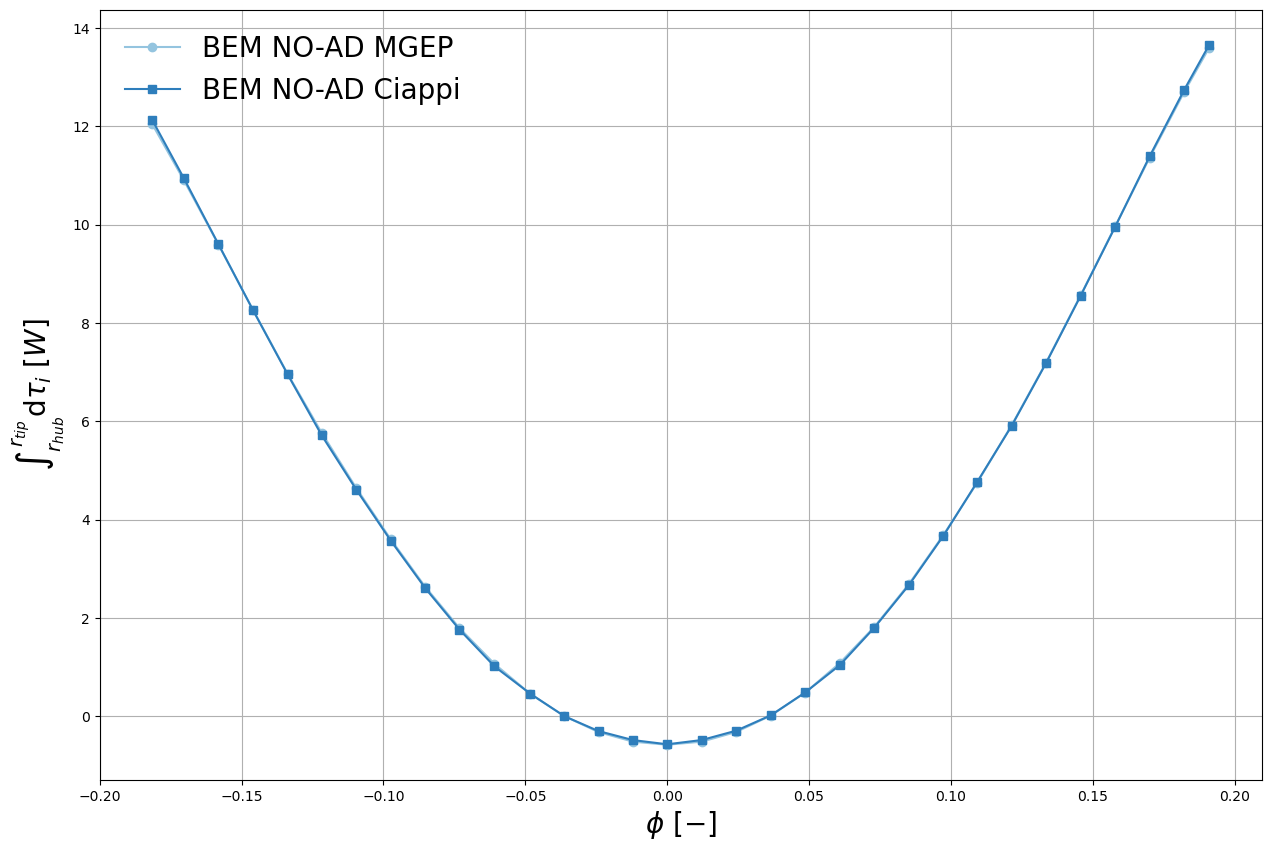

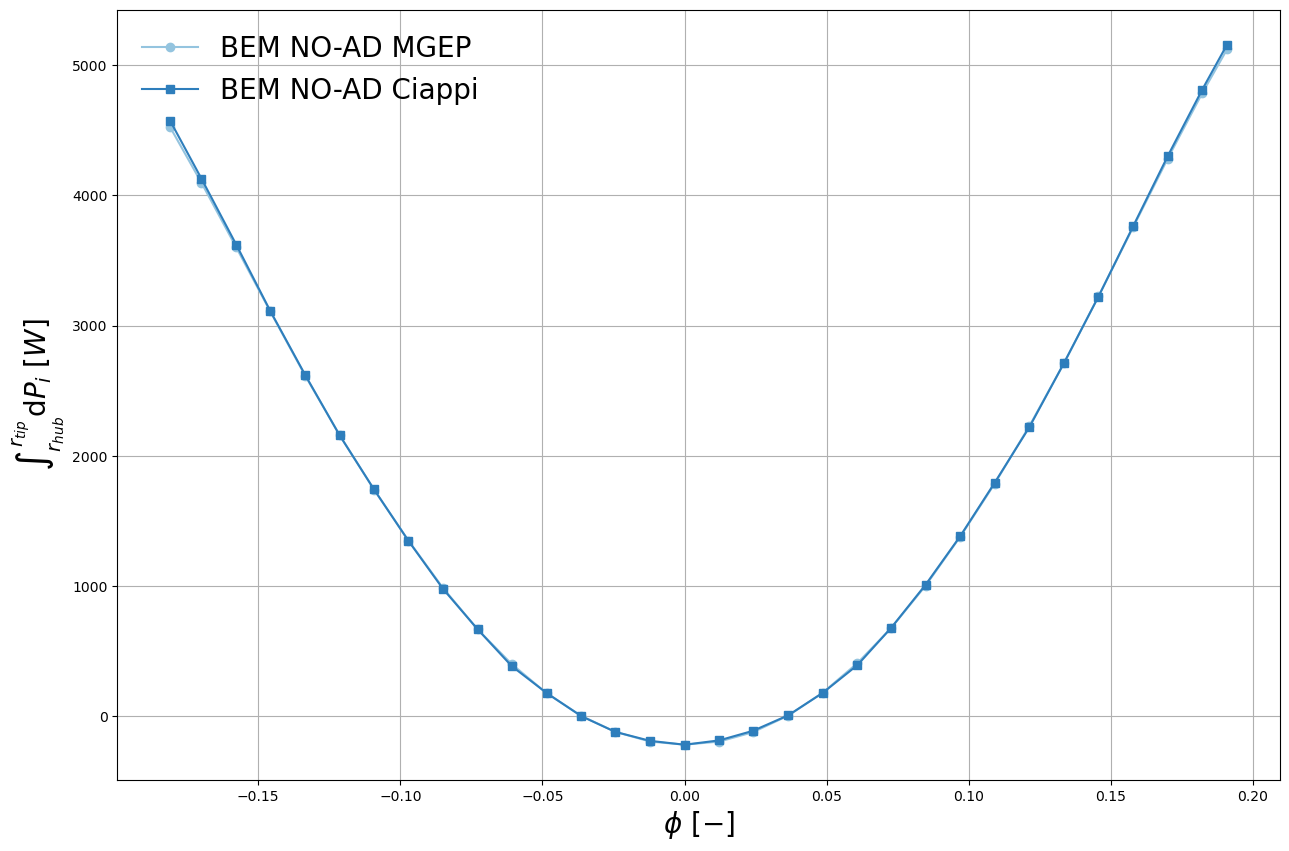

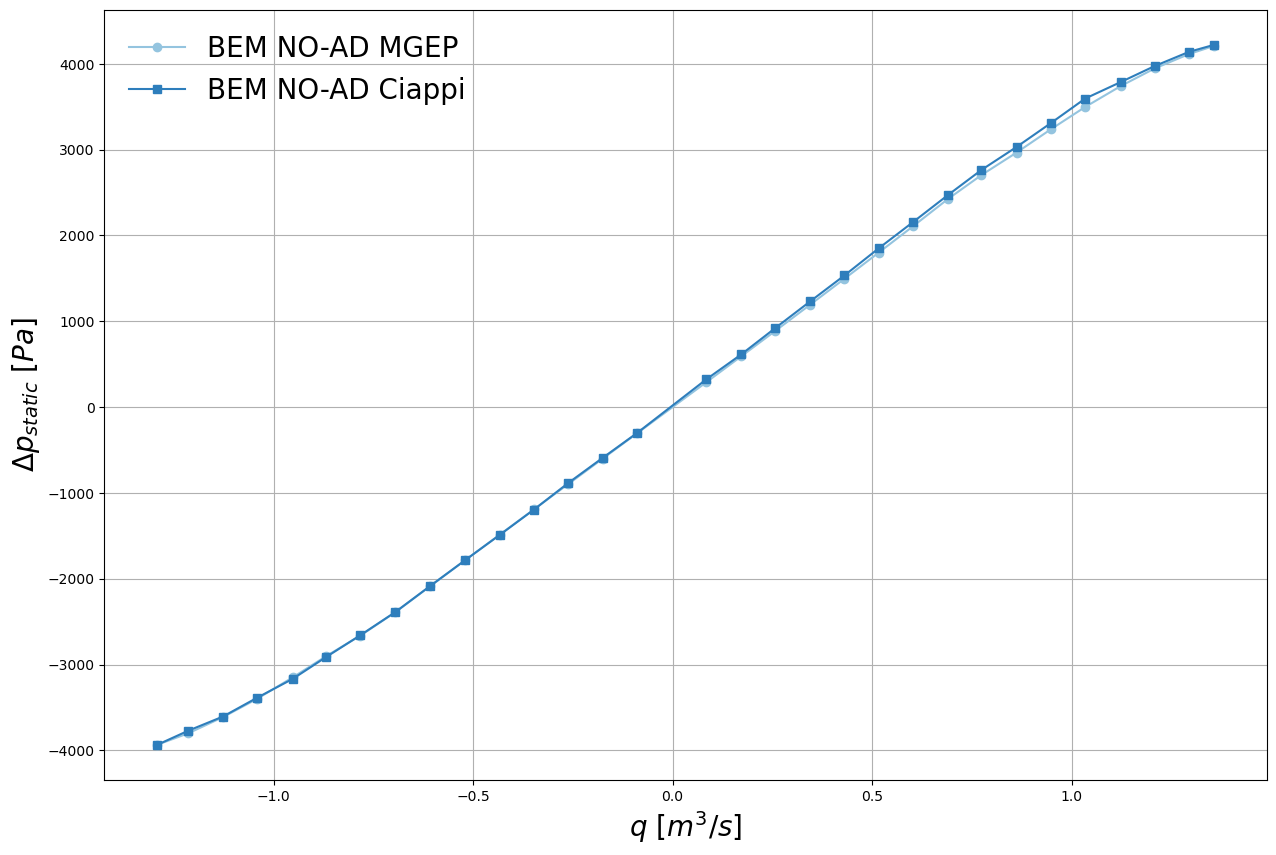

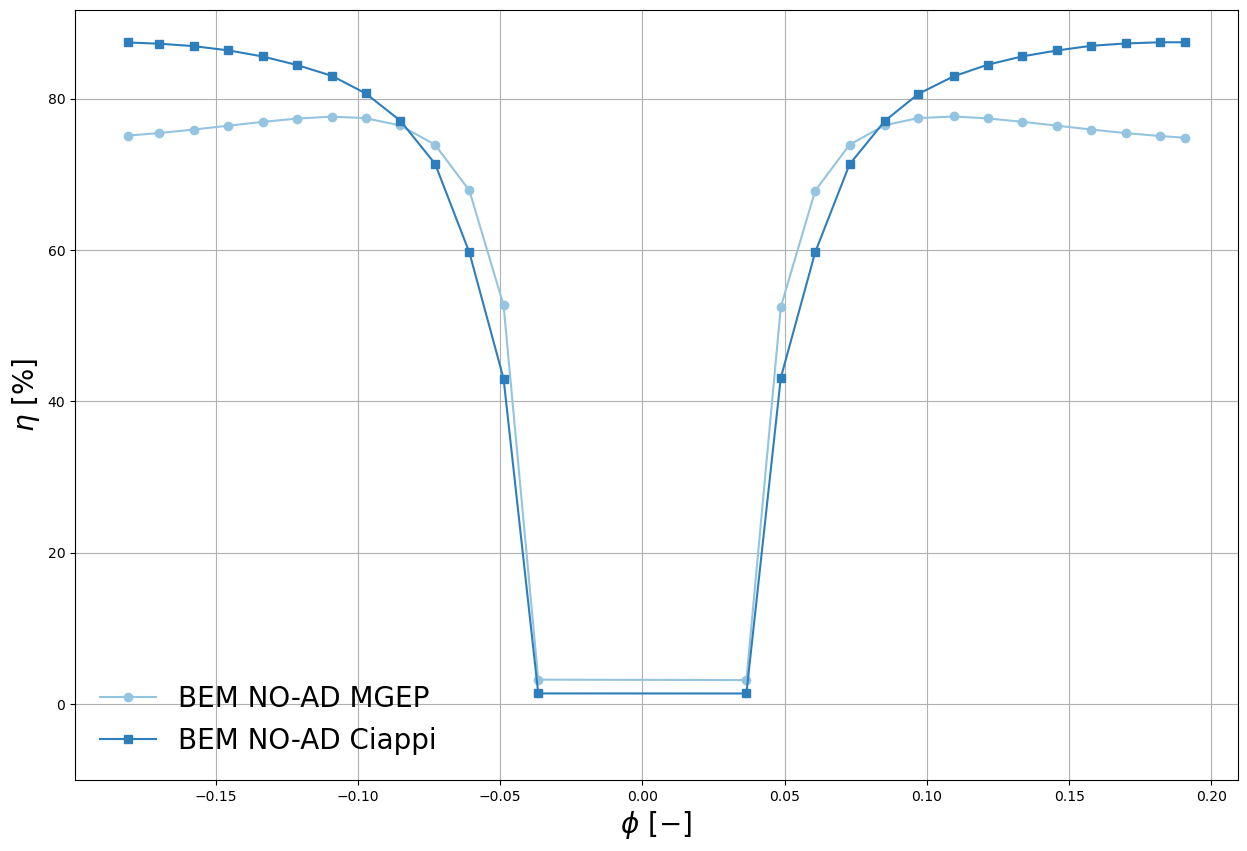

In [30]:
# Setting a list of lists with the x-axis and y-axis labels for the figures.
labels = [["$\\phi \\ [-]$", "$\\int_{r_{hub}}^{r_{tip}}\\mathrm{d}\\tau_{i} \\ [W]$"],
          ["$\\phi \\ [-]$", "$\\int_{r_{hub}}^{r_{tip}}\\mathrm{d}P_{i} \\ [W]$"],
          ["$q \\ [m^{3}/s]$", "$\\Delta{p}_{static} \\ [Pa]$"],
          ["$\\phi \\ [-]$", "$\\eta \\ [\\%]$"]]

# Running over the output lists for plotting them sequentially.
for e, output_list in enumerate(output_lists):
    # Generating figure.
    plt.figure(figsize=(15, 10))
    
    #Plotting statements.
    plt.plot(output_lists[e][0], output_lists[e][1],
            marker="o",
            color = colors[0],
            label="BEM NO-AD MGEP")
    plt.plot(Ciappi_output_lists[e][0], Ciappi_output_lists[e][1],
            marker="s",
            color=colors[1],
            label="BEM NO-AD Ciappi")
    
    #####
    ##### Figure configuration statements.
    #####
    # X label.
    plt.xlabel(labels[e][0], fontsize=20)
    # Y label.
    plt.ylabel(labels[e][1], fontsize=20)
    # Legend.
    plt.legend(fontsize=20, frameon=False)
    # Conditional for setting specific limits in case the efficiency parameter is plotted.
    if "eta" in labels[e][1]:
        ylims = plt.gca().get_ylim()
        plt.ylim((-10, ylims[1]))
    # Grid.
    plt.grid()    

<a id=COMPARISONS-CIAPPI-DATA-BEM-NO-AD-DATASET2></a>
#### DATASET 2

Executing BEMs.

In [23]:
# Instantiating turbine stage with 0 tip-percent (comparison with Ciappi).
turb = turbine_stage(tip_percent=0)

# Instantiating 'tau' variable as a list for storing the output torque values.
taus = list()

# For loop on the input axial velocities provided by Ciappi.
for e, _ in enumerate(CiappiAxialVel):
    # Setting the inlet pressure value of the turbine to that of Ciappi's.
    turb.fp.p = Ciappipres[e]
    # Calling the BEM method with no actuator disk, and input parameter set to axial velocity.
    turb.BEM(_, polars=polars, inputparam='vx')
    # Appending the output torque value to the 'taus' list.
    taus.append(turb.eout.tau)

Plotting.

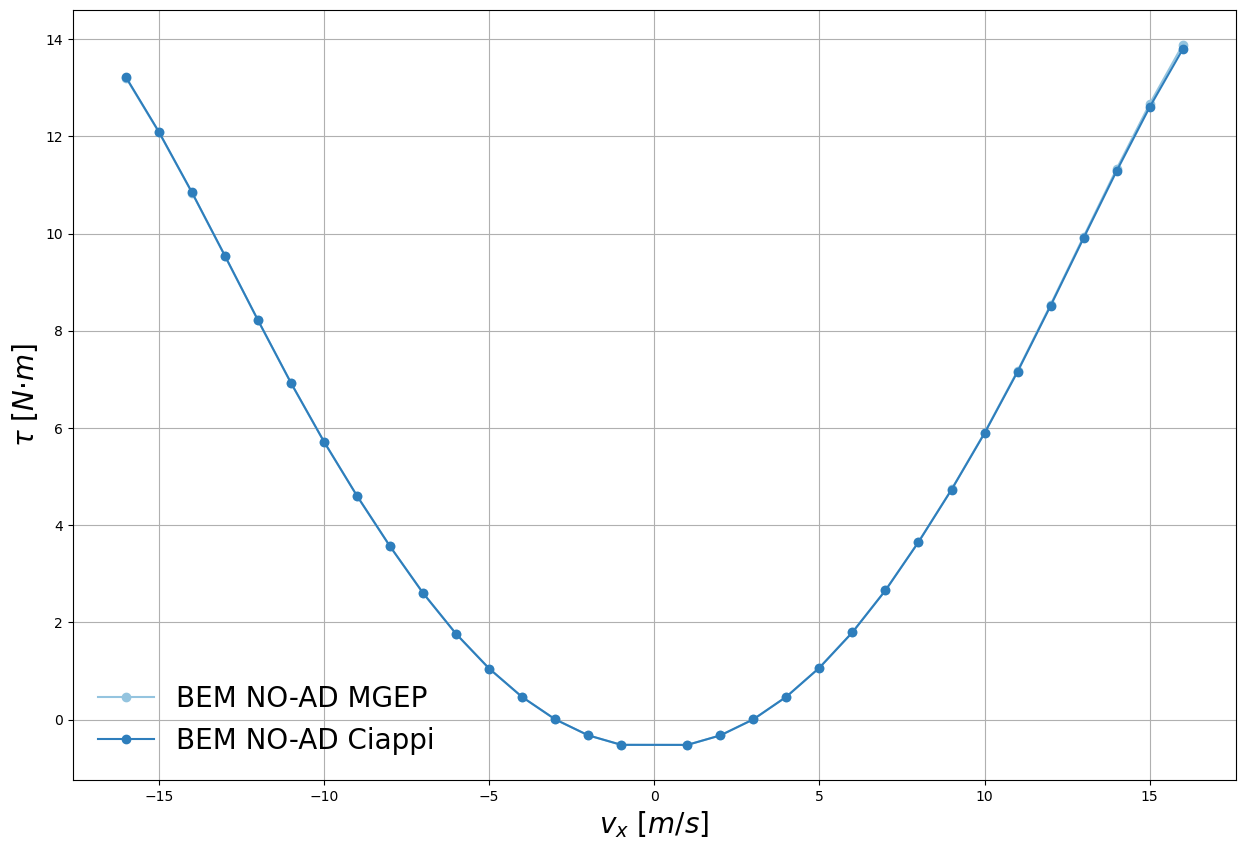

In [24]:
# Instantiating 'colors' variable for storing blue colors coming from the 'Blues' palette.
colors = mpl.cm.__getattribute__("Blues")(np.linspace(0.4, 1, 3))

# Generating figure.
plt.figure(figsize=(15, 10))

# Plot statements.
plt.plot(CiappiAxialVel, taus, marker='o', color=colors[0], label='BEM NO-AD MGEP')
plt.plot(CiappiAxialVel, Ciappitau2, marker='o', color=colors[1], label='BEM NO-AD Ciappi')

#####
##### Figure configuration statements.
#####
# X label.
plt.xlabel('$v_{x} \\ [m/s]$', fontsize=20)
# Y label.
plt.ylabel('$\\tau \\ [N·m]$', fontsize=20)
# Legend.
plt.legend(fontsize=20, frameon=False)
# Grid.
plt.grid()

<a id=COMPARISONS-CIAPPI-DATA-BEM-AD></a>
### BEM MODEL WITH ACTUATOR-DISK

<a id=COMPARISONS-CIAPPI-DATA-BEM-AD-DATASET2-COMPARISON></a>
#### DATASET 2 COMPARISON BETWEEN 3DAD AND 3DNOAD

Executing BEMs

In [76]:
#  Instantiating turbine stages with 0 tip-percent (comparison with Ciappi): 'turbNOAD' to be executed with a BEM method without AD, and 'turbAD' to be executed with a BEM methods with AD.
turbNOAD = turbine_stage(tip_percent=0)
turbAD = turbine_stage(tip_percent=0)

# Instantiating 'tausNOAD' and 'tausAD' variables as lists for storing the output torque values.
tausNOAD = list()
tausAD = list()
# Instantiating 'vthetaNOAD' and 'vthetaAD' variables as lists for storing the output absolute tangential velocities.
vthetaNOAD = list()
vthetaAD = list()

# For loop on the input axial velocities provided by Ciappi.
for e, _ in enumerate(CiappiAxialVeltanvelvar):
    # Setting the input atmospheric pressures to those of Ciappi's.
    turbNOAD.fp.p = Ciappipres[e + 1]
    turbAD.fp.p = Ciappipres[e + 1]    
    # Executing BEM without AD.
    turbNOAD.BEM(_, polars=polars, inputparam='vx', mode='3DNOAD')        
    # Executing BEM with AD.
    turbAD.BEM(_, polars=polars, inputparam='vx', mode='3DAD')    
    # Appending results to output lists.
    tausNOAD.append(turbNOAD.eout.tau)    
    tausAD.append(turbAD.eout.tau)    
    vthetaNOAD.append((turbNOAD.ot.vtheta[len(turbNOAD.ot.vtheta)//2]))
    vthetaAD.append((turbAD.ot.vtheta[len(turbAD.ot.vtheta)//2]))    

Plotting.

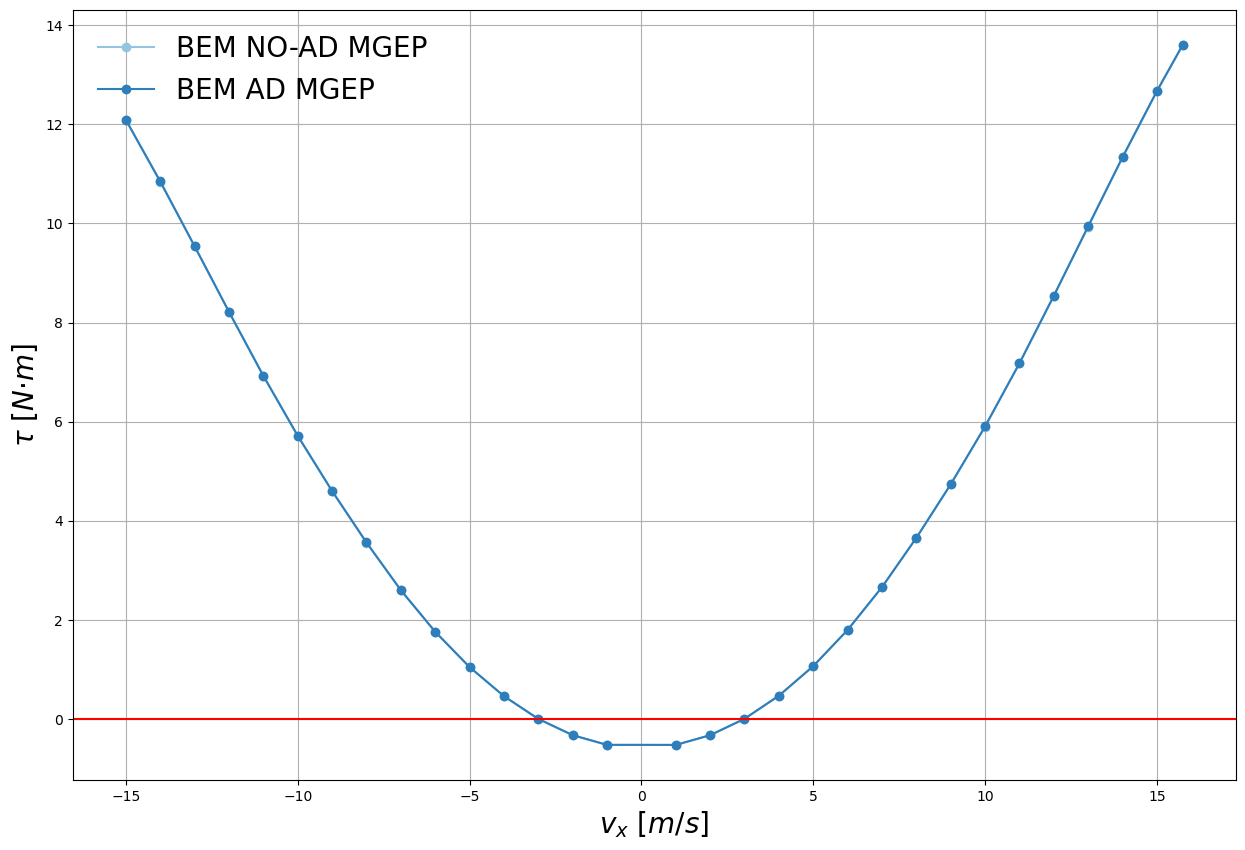

In [77]:
# Instantiating 'colors' variable for storing blue colors coming from the 'Blues' palette.
colors = mpl.cm.__getattribute__("Blues")(np.linspace(0.4, 1, 3))

# Generating figure.
plt.figure(figsize=(15, 10))

# Plot statements.
plt.plot(CiappiAxialVeltanvelvar, tausNOAD, marker='o', color=colors[0], label="BEM NO-AD MGEP")
plt.plot(CiappiAxialVeltanvelvar, tausAD, marker='o', color=colors[1], label="BEM AD MGEP")

# Getting x- and y-limits.
xlims = plt.gca().get_xlim()
ylims = plt.gca().get_ylim()

# Plotting red-colored line upon the x-axis for distinguishing it clearly.
plt.plot([xlims[0], xlims[1]], [0, 0], color='r')

# Resetting axes limits for avoiding seeing the ends of the horizontal line.
plt.gca().set_xlim([xlims[0], xlims[1]])
plt.gca().set_ylim([ylims[0], ylims[1]])

#####
##### Figure configuration statements.
#####
# X label.
plt.xlabel('$v_{x} \\ [m/s]$', fontsize=20)
# Y label.
plt.ylabel('$\\tau \\ [N·m]$', fontsize=20)
# Legend.
plt.legend(fontsize=20, frameon=False)
# Grid
plt.grid()

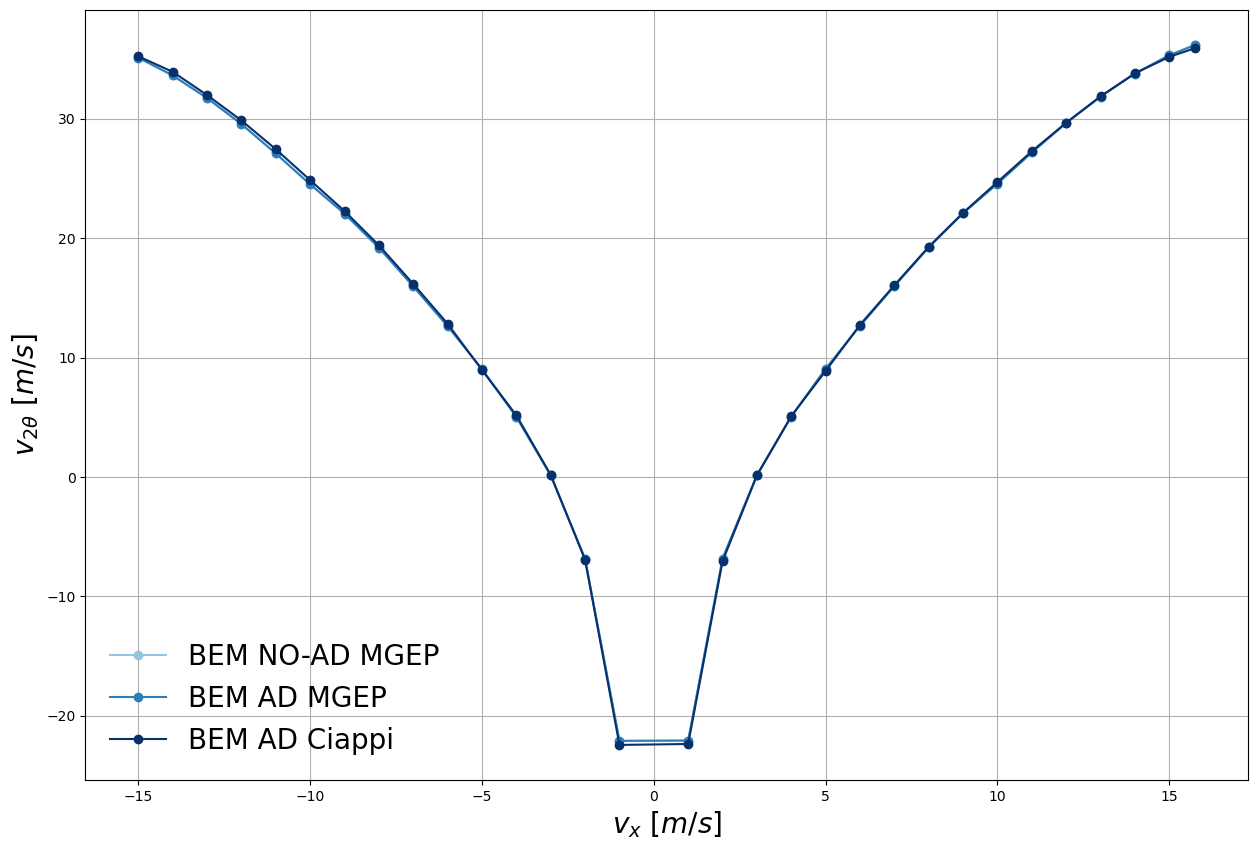

In [79]:
# Instantiating 'colors' variable for storing blue colors coming from the 'Blues' palette.
colors = mpl.cm.__getattribute__("Blues")(np.linspace(0.4, 1, 3))

# Generating figure.
plt.figure(figsize=(15, 10))

# Plot statements.
plt.plot(CiappiAxialVeltanvelvar, maxtanvelnoad, marker='o', color=colors[0], label='BEM NO-AD MGEP')
plt.plot(CiappiAxialVeltanvelvar, maxtanvelad, marker='o', color=colors[1], label='BEM AD MGEP')
plt.plot(CiappiAxialVeltanvelvar, Ciappitanvelvar, marker='o', color=colors[2], label='BEM AD Ciappi')

#####
##### Figure configuration statements.
#####
# X label.
plt.xlabel('$v_{x} \\ [m/s]$', fontsize=20)
# Y label.
plt.ylabel('$v_{2\\theta} \\ [m/s]$', fontsize=20)
# Legend.
plt.legend(fontsize=20, frameon=False)
# Grid
plt.grid()